XGBoost is a very recently developed algorithm (2016). Thus, it's not yet there in standard textbooks. Here are some resources for it.

[Documentation](https://xgboost.readthedocs.io/en/stable/python/python_api.html)

[Slides](https://files.speakerdeck.com/presentations/5c6dab45648344208185d2b1ab4fdc95/XGBoost-Newest.pdf)

[Reference paper](https://dl.acm.org/doi/pdf/10.1145/2939672.2939785)

## Hyperparameters

There are 5 important parameters to tune in XGBoost:

1. Number of trees 

2. Depth of each tree 

3. Learning rate 

4. Subsample fraction

5. Regularization parameters (`reg_lambda` & `gamma`)

However, there are other hyperparameters that can be tuned as well. Check out the list of all hyperparameters in the XGBoost [documentation](https://xgboost.readthedocs.io/en/stable/python/python_api.html#).

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth

In [16]:
#Using the same datasets as used for linear regression in STAT303-2, 
#so that we can compare the non-linear models with linear regression
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')
train = pd.merge(trainf,trainp)
test = pd.merge(testf,testp)
train.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,18473,bmw,6 Series,2020,Semi-Auto,11,Diesel,145,53.3282,3.0,37980
1,15064,bmw,6 Series,2019,Semi-Auto,10813,Diesel,145,53.0430,3.0,33980
2,18268,bmw,6 Series,2020,Semi-Auto,6,Diesel,145,53.4379,3.0,36850
3,18480,bmw,6 Series,2017,Semi-Auto,18895,Diesel,145,51.5140,3.0,25998
4,18492,bmw,6 Series,2015,Automatic,62953,Diesel,160,51.4903,3.0,18990


In [17]:
X = train[['mileage','mpg','year','engineSize']]
Xtest = test[['mileage','mpg','year','engineSize']]
y = train['price']
ytest = test['price']

## XGBoost for regression

### Number of trees vs cross validation error
As the number of trees increase, the prediction bias will decrease, and the prediction variance will increase. Thus, there will be an optimal number of trees that minimize the prediction error.

>5 7961.485 (192.906)
>10 5837.134 (217.986)
>50 5424.788 (263.890)
>100 5465.396 (237.938)
>500 5608.350 (235.903)
>1000 5635.159 (236.664)
>2000 5642.669 (236.192)
>5000 5643.411 (236.074)


Text(0.5, 0, 'Number of trees')

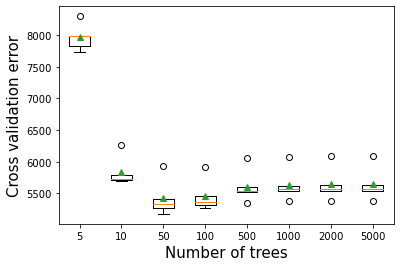

In [10]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [5, 10, 50, 100, 500, 1000, 2000, 5000]
    for n in n_trees:
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

### Depth of tree vs cross validation error
As the depth of each weak learner (decision tree) increases, the complexity of the weak learner will increase. As the complexity increases, the prediction bias will decrease, while the prediction variance will increase. Thus, there will be an optimal depth of each weak learner that minimizes the prediction error.

>1 7541.827 (545.951)
>2 6129.425 (393.357)
>3 5647.783 (454.318)
>4 5438.481 (453.726)
>5 5358.074 (379.431)
>6 5281.675 (383.848)
>7 5495.163 (459.356)
>8 5399.145 (380.437)
>9 5469.563 (384.004)
>10 5461.549 (416.630)
>11 5443.210 (432.863)
>12 5546.447 (412.097)
>13 5532.414 (369.131)
>14 5556.761 (362.746)
>15 5540.366 (452.612)
>16 5586.004 (451.199)
>17 5563.137 (464.344)
>18 5594.919 (480.221)
>19 5641.226 (451.713)
>20 5616.462 (417.405)


Text(0.5, 0, 'Depth of each tree')

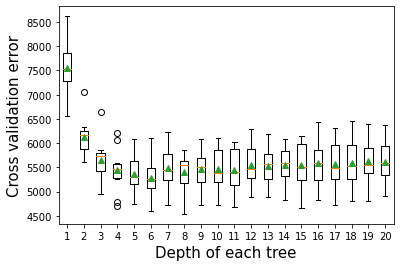

In [11]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define ensemble model
        models[str(i)] = xgb.XGBRegressor(random_state=1,max_depth=i)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

### Learning rate vs cross validation error
The optimal learning rate will depend on the number of trees, and vice-versa. If the learning rate is too low, it will take several trees to "learn" the response. If the learning rate is high, the response will be "learned" quickly (with fewer) trees.  Learning too quickly will be prone to overfitting, while learning too slowly will be computationally expensive. Thus, there will be an optimal learning rate to minimize the prediction error.

>0.0100 12223.8 (636.7)
>0.0500 5298.5 (383.5)
>0.1000 5236.3 (397.5)
>0.2000 5221.5 (347.5)
>0.3000 5281.7 (383.8)
>0.4000 5434.1 (364.6)
>0.5000 5537.0 (471.9)
>0.6000 5767.4 (478.5)
>0.8000 6132.7 (472.5)
>1.0000 6593.6 (408.9)


Text(0.5, 0, 'Learning rate')

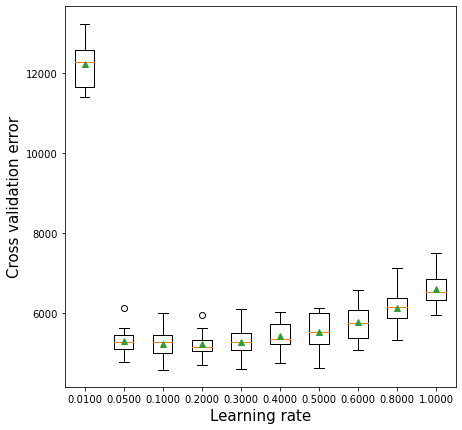

In [22]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

### Regularization (*reg_lambda*) vs cross validation error

The parameter `reg_lambda` penalizes the *L2 norm* of the leaf scores. For example, in case of classification, it will penalize the summation of the square of log odds of the predicted probability. This penalization will tend to reduce the log odds, thereby reducing the tendency to overfit. "*Reducing the log odds*" in layman terms will mean not being overly sure about the prediction.

Without regularization, the algorithm will be closer to the gradient boosting algorithm. Regularization may provide some additional boost to prediction accuracy by reducing over-fitting. In the example below, regularization with *`reg_lambda=1` turns out to be better than no regularization *(`reg_lambda=0`)*. Of course, too much regularization may increase bias so much such that it leads to a decrease in prediction accuracy.

>0.0000 5359.2 (317.0)
>0.5000 5382.7 (363.1)
>1.0000 5281.7 (383.8)
>1.5000 5348.0 (383.9)
>2.0000 5336.4 (426.6)
>10.0000 5410.9 (521.9)
>100.0000 5801.1 (563.7)


Text(0.5, 0, 'reg_lambda')

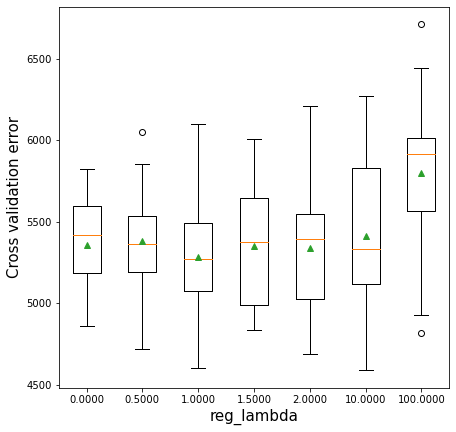

In [4]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0,0.5,1.0,1.5,2,10,100]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

## Regularization (*gamma*) vs cross validation error

The parameter `gamma` penalizes the tree based on the number of leaves. This is similar to the parameter `alpha` of cost complexity pruning. As `gamma` increases, more leaves will be pruned. Note that the previous parameter `reg_lambda` penalizes the leaf score, but does not prune the tree.

Without regularization, the algorithm will be closer to the gradient boosting algorithm. Regularization may provide some additional boost to prediction accuracy by reducing over-fitting. However, in the example below, no regularization (in terms of `gamma=0`) turns out to be better than a non-zero regularization. *(`reg_lambda=0`)*.

>0.0000 5281.7 (383.8)
>10.0000 5281.7 (383.8)
>100.0000 5281.7 (383.8)
>1000.0000 5291.8 (381.8)
>10000.0000 5295.7 (370.2)
>100000.0000 5293.0 (402.5)
>1000000.0000 5322.2 (368.9)
>10000000.0000 5273.7 (409.8)
>100000000.0000 5362.1 (407.8)
>1000000000.0000 5932.3 (397.6)


Text(0.5, 0, 'gamma')

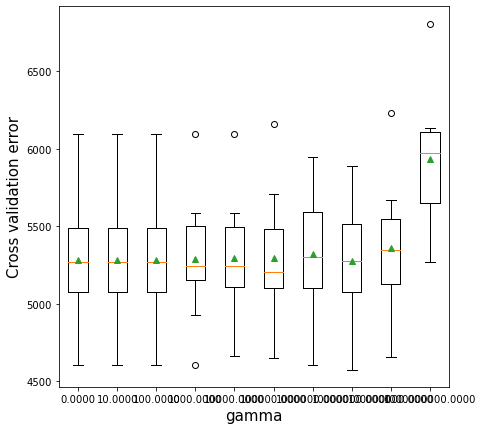

In [6]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(gamma=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('gamma',fontsize=15)

### Tuning XGboost regressor
Along with `max_depth`, `learning_rate`, and `n_estimators`, here we tune `reg_lambda` - the regularization parameter for penalizing the tree predictions.

In [291]:
#K-fold cross validation to find optimal parameters for XGBoost
start_time = time.time()
param_grid = {'max_depth': [5,6,7],
              'learning_rate': [0.01,0.05,0.1,0.2],
               'reg_lambda':[0,0.01,0.001],
                'n_estimators':[150,175,250,500,1000]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,                             
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X,y)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", (time.time()-start_time)/60, " minutes")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Optimal parameter values = {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 150, 'reg_lambda': 0.001}
Optimal cross validation R-squared =  0.897270156754803
Time taken =  6.336081512769064  minutes


The above values of the parameters correspond to the highest cross validation R-squared. However, other values could also provide a similar R-squared. Parameter values with a lower learning rate that provide a similar R-squared may provide a better model. This is because a lower learning rate reduces the tendency to overfit. 

Let us sort the cross validation R-squared, and have a look at other parameter values that provide an R-squared close to the optimal R-squared.

In [52]:
cv_results=pd.DataFrame(optimal_params.cv_results_)
cv_results.sort_values(by = 'mean_test_score',ascending=False)[1:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
68,4.645018,0.044068,0.009754,0.001648,0.05,6,250,0.001,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.882000,0.911849,0.907002,0.888711,0.896318,0.897176,0.011086,2
110,2.942980,0.075181,0.007105,0.001718,0.1,6,175,0.001,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.886817,0.912079,0.903889,0.887301,0.895308,0.897079,0.009751,3
70,8.663175,0.193121,0.012708,0.002762,0.05,6,500,0.01,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.879380,0.910923,0.907290,0.889626,0.896315,0.896707,0.011529,4
28,12.433029,0.450372,0.015924,0.000151,0.01,6,1000,0.01,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",0.879470,0.911039,0.905411,0.888670,0.898379,0.896594,0.011363,5


Note that the parameter values with *learning rate = 0.01, max_depth = 6, n_estimators = 1000, and reg_lambda = 0.01* provide a similar cross validation R-squared of approx. 90%. This is set of parameter values with a lower learning may provide a better model fit.

Let us compute the RMSE for both sets of optimal parameter values - the optimal one, and the set of values with a lower learning rate that provide almost the optimal cross validation R-squared.

In [14]:
#RMSE based on the optimal parameter values
model = xgb.XGBRegressor(random_state=1,max_depth=6,n_estimators=150,
                                         learning_rate = 0.1,reg_lambda=0.001)
model.fit(X,y)
np.sqrt(mean_squared_error(model.predict(Xtest),ytest))

5666.525834683286

In [7]:
#RMSE based on the parameter values that provide a cross validation R-squared close to the optimal one
model = xgb.XGBRegressor(random_state=1,max_depth=6,n_estimators=1000,
                                         learning_rate = 0.01,reg_lambda=0.01)
model.fit(X,y)
np.sqrt(mean_squared_error(model.predict(Xtest),ytest))

5538.865803458487

Note that a lower learning rate is likely to provide a better model.

## Early stopping with XGBoost
If we have a test dataset *(or we can further split the train data into a smaller train and test data)*, we can use it with the `early_stopping_rounds` argument of XGBoost, where it will stop growing trees once the model accuracy fails to increase for a certain number of consecutive iterations, given as `early_stopping_rounds`.

In [20]:
#| eval: false
model = xgb.XGBRegressor(random_state = 1, max_depth = 6, learning_rate = 0.001,
                        n_estimators = 20000,reg_lambda = 0.01)
model.fit(X,y, eval_set = ([(Xtest,ytest)]), early_stopping_rounds = 10)

[0]	validation_0-rmse:28975.29198
[1]	validation_0-rmse:28948.19448
[2]	validation_0-rmse:28921.12645
[3]	validation_0-rmse:28894.08694
[4]	validation_0-rmse:28867.07676
[5]	validation_0-rmse:28840.09585
[6]	validation_0-rmse:28813.14419
[7]	validation_0-rmse:28786.22176
[8]	validation_0-rmse:28759.32804
[9]	validation_0-rmse:28732.46338
[10]	validation_0-rmse:28705.62784
[11]	validation_0-rmse:28678.82254
[12]	validation_0-rmse:28652.04509
[13]	validation_0-rmse:28625.30330
[14]	validation_0-rmse:28598.58391
[15]	validation_0-rmse:28571.90015
[16]	validation_0-rmse:28545.23772
[17]	validation_0-rmse:28518.61115
[18]	validation_0-rmse:28492.01626
[19]	validation_0-rmse:28465.44215
[20]	validation_0-rmse:28438.89872
[21]	validation_0-rmse:28412.38778
[22]	validation_0-rmse:28385.90162
[23]	validation_0-rmse:28359.44755
[24]	validation_0-rmse:28333.01856
[25]	validation_0-rmse:28306.62172
[26]	validation_0-rmse:28280.15770
[27]	validation_0-rmse:28253.81818
[28]	validation_0-rmse:28227.4

[231]	validation_0-rmse:23439.14033
[232]	validation_0-rmse:23417.91246
[233]	validation_0-rmse:23396.91310
[234]	validation_0-rmse:23375.65537
[235]	validation_0-rmse:23354.73159
[236]	validation_0-rmse:23333.63133
[237]	validation_0-rmse:23312.69790
[238]	validation_0-rmse:23291.71495
[239]	validation_0-rmse:23270.82272
[240]	validation_0-rmse:23249.72998
[241]	validation_0-rmse:23228.99508
[242]	validation_0-rmse:23208.01315
[243]	validation_0-rmse:23187.17765
[244]	validation_0-rmse:23166.30464
[245]	validation_0-rmse:23145.59044
[246]	validation_0-rmse:23124.67270
[247]	validation_0-rmse:23103.94401
[248]	validation_0-rmse:23083.10505
[249]	validation_0-rmse:23062.57242
[250]	validation_0-rmse:23041.66419
[251]	validation_0-rmse:23021.09311
[252]	validation_0-rmse:23000.37763
[253]	validation_0-rmse:22979.88099
[254]	validation_0-rmse:22959.13864
[255]	validation_0-rmse:22938.73394
[256]	validation_0-rmse:22917.97729
[257]	validation_0-rmse:22897.44597
[258]	validation_0-rmse:2287

[459]	validation_0-rmse:19164.58041
[460]	validation_0-rmse:19147.78370
[461]	validation_0-rmse:19131.23131
[462]	validation_0-rmse:19114.90926
[463]	validation_0-rmse:19098.21159
[464]	validation_0-rmse:19081.68772
[465]	validation_0-rmse:19065.43657
[466]	validation_0-rmse:19048.77786
[467]	validation_0-rmse:19032.50973
[468]	validation_0-rmse:19016.03964
[469]	validation_0-rmse:18999.44189
[470]	validation_0-rmse:18983.22787
[471]	validation_0-rmse:18967.09882
[472]	validation_0-rmse:18950.71997
[473]	validation_0-rmse:18934.20447
[474]	validation_0-rmse:18917.90894
[475]	validation_0-rmse:18901.79568
[476]	validation_0-rmse:18885.31548
[477]	validation_0-rmse:18869.26333
[478]	validation_0-rmse:18852.83236
[479]	validation_0-rmse:18836.56024
[480]	validation_0-rmse:18820.57332
[481]	validation_0-rmse:18804.15133
[482]	validation_0-rmse:18788.16747
[483]	validation_0-rmse:18771.82666
[484]	validation_0-rmse:18755.64375
[485]	validation_0-rmse:18739.73368
[486]	validation_0-rmse:1872

[687]	validation_0-rmse:15815.24637
[688]	validation_0-rmse:15802.32397
[689]	validation_0-rmse:15789.44318
[690]	validation_0-rmse:15776.55094
[691]	validation_0-rmse:15763.64729
[692]	validation_0-rmse:15750.66969
[693]	validation_0-rmse:15737.68556
[694]	validation_0-rmse:15724.86979
[695]	validation_0-rmse:15712.17353
[696]	validation_0-rmse:15699.35747
[697]	validation_0-rmse:15686.35976
[698]	validation_0-rmse:15673.56058
[699]	validation_0-rmse:15660.78611
[700]	validation_0-rmse:15648.03244
[701]	validation_0-rmse:15635.44461
[702]	validation_0-rmse:15622.60480
[703]	validation_0-rmse:15609.89163
[704]	validation_0-rmse:15597.19435
[705]	validation_0-rmse:15584.49604
[706]	validation_0-rmse:15571.69620
[707]	validation_0-rmse:15559.09189
[708]	validation_0-rmse:15546.48281
[709]	validation_0-rmse:15533.75275
[710]	validation_0-rmse:15521.15535
[711]	validation_0-rmse:15508.56262
[712]	validation_0-rmse:15496.10489
[713]	validation_0-rmse:15483.40852
[714]	validation_0-rmse:1547

[915]	validation_0-rmse:13211.48972
[916]	validation_0-rmse:13201.54955
[917]	validation_0-rmse:13191.41140
[918]	validation_0-rmse:13181.25479
[919]	validation_0-rmse:13171.19438
[920]	validation_0-rmse:13161.04533
[921]	validation_0-rmse:13151.20125
[922]	validation_0-rmse:13141.08867
[923]	validation_0-rmse:13131.02196
[924]	validation_0-rmse:13121.01731
[925]	validation_0-rmse:13110.92419
[926]	validation_0-rmse:13101.02985
[927]	validation_0-rmse:13091.02374
[928]	validation_0-rmse:13081.07532
[929]	validation_0-rmse:13071.03627
[930]	validation_0-rmse:13061.02230
[931]	validation_0-rmse:13051.14461
[932]	validation_0-rmse:13041.42591
[933]	validation_0-rmse:13031.45511
[934]	validation_0-rmse:13021.52471
[935]	validation_0-rmse:13011.61891
[936]	validation_0-rmse:13001.71263
[937]	validation_0-rmse:12991.86340
[938]	validation_0-rmse:12981.98715
[939]	validation_0-rmse:12972.30251
[940]	validation_0-rmse:12962.38529
[941]	validation_0-rmse:12952.54521
[942]	validation_0-rmse:1294

[1139]	validation_0-rmse:11218.99862
[1140]	validation_0-rmse:11211.15191
[1141]	validation_0-rmse:11203.31801
[1142]	validation_0-rmse:11195.64707
[1143]	validation_0-rmse:11187.83684
[1144]	validation_0-rmse:11180.06307
[1145]	validation_0-rmse:11172.33821
[1146]	validation_0-rmse:11164.65267
[1147]	validation_0-rmse:11156.96964
[1148]	validation_0-rmse:11149.26221
[1149]	validation_0-rmse:11141.60476
[1150]	validation_0-rmse:11133.94601
[1151]	validation_0-rmse:11126.43192
[1152]	validation_0-rmse:11118.80955
[1153]	validation_0-rmse:11111.16086
[1154]	validation_0-rmse:11103.57054
[1155]	validation_0-rmse:11095.91867
[1156]	validation_0-rmse:11088.45593
[1157]	validation_0-rmse:11080.88586
[1158]	validation_0-rmse:11073.23559
[1159]	validation_0-rmse:11065.80201
[1160]	validation_0-rmse:11058.18895
[1161]	validation_0-rmse:11050.77156
[1162]	validation_0-rmse:11043.27514
[1163]	validation_0-rmse:11035.71030
[1164]	validation_0-rmse:11028.17515
[1165]	validation_0-rmse:11020.61868
[

[1362]	validation_0-rmse:9717.89020
[1363]	validation_0-rmse:9712.20210
[1364]	validation_0-rmse:9706.33406
[1365]	validation_0-rmse:9700.68169
[1366]	validation_0-rmse:9694.91729
[1367]	validation_0-rmse:9689.05418
[1368]	validation_0-rmse:9683.48661
[1369]	validation_0-rmse:9677.86521
[1370]	validation_0-rmse:9672.23809
[1371]	validation_0-rmse:9666.44255
[1372]	validation_0-rmse:9660.82964
[1373]	validation_0-rmse:9655.32211
[1374]	validation_0-rmse:9649.72945
[1375]	validation_0-rmse:9643.93346
[1376]	validation_0-rmse:9638.39361
[1377]	validation_0-rmse:9632.82028
[1378]	validation_0-rmse:9627.34026
[1379]	validation_0-rmse:9621.55657
[1380]	validation_0-rmse:9616.02385
[1381]	validation_0-rmse:9610.48492
[1382]	validation_0-rmse:9604.74679
[1383]	validation_0-rmse:9599.31824
[1384]	validation_0-rmse:9593.80184
[1385]	validation_0-rmse:9588.30935
[1386]	validation_0-rmse:9582.59982
[1387]	validation_0-rmse:9577.07247
[1388]	validation_0-rmse:9571.32949
[1389]	validation_0-rmse:956

[1590]	validation_0-rmse:8578.49111
[1591]	validation_0-rmse:8574.24570
[1592]	validation_0-rmse:8569.98952
[1593]	validation_0-rmse:8565.68752
[1594]	validation_0-rmse:8561.44600
[1595]	validation_0-rmse:8557.15053
[1596]	validation_0-rmse:8552.87270
[1597]	validation_0-rmse:8548.59971
[1598]	validation_0-rmse:8544.26059
[1599]	validation_0-rmse:8539.97798
[1600]	validation_0-rmse:8535.78831
[1601]	validation_0-rmse:8531.51407
[1602]	validation_0-rmse:8527.28822
[1603]	validation_0-rmse:8522.97858
[1604]	validation_0-rmse:8518.73156
[1605]	validation_0-rmse:8514.56631
[1606]	validation_0-rmse:8510.34604
[1607]	validation_0-rmse:8506.21234
[1608]	validation_0-rmse:8502.01348
[1609]	validation_0-rmse:8497.76369
[1610]	validation_0-rmse:8493.55384
[1611]	validation_0-rmse:8489.41129
[1612]	validation_0-rmse:8485.19192
[1613]	validation_0-rmse:8481.00368
[1614]	validation_0-rmse:8476.85057
[1615]	validation_0-rmse:8472.62424
[1616]	validation_0-rmse:8468.45935
[1617]	validation_0-rmse:846

[1818]	validation_0-rmse:7753.49148
[1819]	validation_0-rmse:7750.41878
[1820]	validation_0-rmse:7747.50500
[1821]	validation_0-rmse:7744.46450
[1822]	validation_0-rmse:7741.32251
[1823]	validation_0-rmse:7738.35620
[1824]	validation_0-rmse:7735.32257
[1825]	validation_0-rmse:7732.27649
[1826]	validation_0-rmse:7729.24086
[1827]	validation_0-rmse:7726.30415
[1828]	validation_0-rmse:7723.24582
[1829]	validation_0-rmse:7720.20585
[1830]	validation_0-rmse:7717.38272
[1831]	validation_0-rmse:7714.44322
[1832]	validation_0-rmse:7711.44663
[1833]	validation_0-rmse:7708.47646
[1834]	validation_0-rmse:7705.60828
[1835]	validation_0-rmse:7702.67666
[1836]	validation_0-rmse:7699.88470
[1837]	validation_0-rmse:7696.92367
[1838]	validation_0-rmse:7693.89671
[1839]	validation_0-rmse:7690.81322
[1840]	validation_0-rmse:7687.84608
[1841]	validation_0-rmse:7684.93026
[1842]	validation_0-rmse:7681.97298
[1843]	validation_0-rmse:7678.97071
[1844]	validation_0-rmse:7676.15917
[1845]	validation_0-rmse:767

[2046]	validation_0-rmse:7152.15530
[2047]	validation_0-rmse:7149.88436
[2048]	validation_0-rmse:7147.75931
[2049]	validation_0-rmse:7145.35318
[2050]	validation_0-rmse:7143.13209
[2051]	validation_0-rmse:7140.99924
[2052]	validation_0-rmse:7138.67250
[2053]	validation_0-rmse:7136.50948
[2054]	validation_0-rmse:7134.10591
[2055]	validation_0-rmse:7131.92015
[2056]	validation_0-rmse:7129.75775
[2057]	validation_0-rmse:7127.50870
[2058]	validation_0-rmse:7125.39051
[2059]	validation_0-rmse:7123.02204
[2060]	validation_0-rmse:7120.79216
[2061]	validation_0-rmse:7118.65605
[2062]	validation_0-rmse:7116.35553
[2063]	validation_0-rmse:7114.19424
[2064]	validation_0-rmse:7111.79675
[2065]	validation_0-rmse:7109.69633
[2066]	validation_0-rmse:7107.55706
[2067]	validation_0-rmse:7105.23948
[2068]	validation_0-rmse:7103.10188
[2069]	validation_0-rmse:7100.97045
[2070]	validation_0-rmse:7098.66903
[2071]	validation_0-rmse:7096.51135
[2072]	validation_0-rmse:7094.63004
[2073]	validation_0-rmse:709

[2274]	validation_0-rmse:6710.24421
[2275]	validation_0-rmse:6708.67382
[2276]	validation_0-rmse:6706.97578
[2277]	validation_0-rmse:6705.47170
[2278]	validation_0-rmse:6703.75526
[2279]	validation_0-rmse:6702.16934
[2280]	validation_0-rmse:6700.61003
[2281]	validation_0-rmse:6698.98056
[2282]	validation_0-rmse:6697.39516
[2283]	validation_0-rmse:6695.82642
[2284]	validation_0-rmse:6694.11702
[2285]	validation_0-rmse:6692.62861
[2286]	validation_0-rmse:6691.01426
[2287]	validation_0-rmse:6689.30207
[2288]	validation_0-rmse:6687.71292
[2289]	validation_0-rmse:6686.21589
[2290]	validation_0-rmse:6684.61337
[2291]	validation_0-rmse:6683.07403
[2292]	validation_0-rmse:6681.36101
[2293]	validation_0-rmse:6679.78119
[2294]	validation_0-rmse:6678.18932
[2295]	validation_0-rmse:6676.49765
[2296]	validation_0-rmse:6674.92536
[2297]	validation_0-rmse:6673.42056
[2298]	validation_0-rmse:6671.96829
[2299]	validation_0-rmse:6670.28763
[2300]	validation_0-rmse:6668.77409
[2301]	validation_0-rmse:666

[2502]	validation_0-rmse:6397.59234
[2503]	validation_0-rmse:6396.51801
[2504]	validation_0-rmse:6395.39183
[2505]	validation_0-rmse:6394.27159
[2506]	validation_0-rmse:6393.23864
[2507]	validation_0-rmse:6392.18645
[2508]	validation_0-rmse:6391.01831
[2509]	validation_0-rmse:6389.95426
[2510]	validation_0-rmse:6388.89217
[2511]	validation_0-rmse:6387.82912
[2512]	validation_0-rmse:6386.73667
[2513]	validation_0-rmse:6385.70390
[2514]	validation_0-rmse:6384.64897
[2515]	validation_0-rmse:6383.41245
[2516]	validation_0-rmse:6382.36248
[2517]	validation_0-rmse:6381.30755
[2518]	validation_0-rmse:6380.27889
[2519]	validation_0-rmse:6379.19984
[2520]	validation_0-rmse:6378.10331
[2521]	validation_0-rmse:6377.07993
[2522]	validation_0-rmse:6375.89824
[2523]	validation_0-rmse:6374.86771
[2524]	validation_0-rmse:6373.90195
[2525]	validation_0-rmse:6372.88521
[2526]	validation_0-rmse:6371.68811
[2527]	validation_0-rmse:6370.62687
[2528]	validation_0-rmse:6369.60491
[2529]	validation_0-rmse:636

[2730]	validation_0-rmse:6184.93753
[2731]	validation_0-rmse:6184.09905
[2732]	validation_0-rmse:6183.35166
[2733]	validation_0-rmse:6182.60286
[2734]	validation_0-rmse:6181.90603
[2735]	validation_0-rmse:6181.15803
[2736]	validation_0-rmse:6180.33366
[2737]	validation_0-rmse:6179.62263
[2738]	validation_0-rmse:6178.81667
[2739]	validation_0-rmse:6178.08830
[2740]	validation_0-rmse:6177.29089
[2741]	validation_0-rmse:6176.59646
[2742]	validation_0-rmse:6175.84222
[2743]	validation_0-rmse:6175.12161
[2744]	validation_0-rmse:6174.38007
[2745]	validation_0-rmse:6173.63281
[2746]	validation_0-rmse:6172.92161
[2747]	validation_0-rmse:6172.22449
[2748]	validation_0-rmse:6171.44800
[2749]	validation_0-rmse:6170.74011
[2750]	validation_0-rmse:6169.92291
[2751]	validation_0-rmse:6169.23209
[2752]	validation_0-rmse:6168.43831
[2753]	validation_0-rmse:6167.71983
[2754]	validation_0-rmse:6166.93438
[2755]	validation_0-rmse:6166.24891
[2756]	validation_0-rmse:6165.51950
[2757]	validation_0-rmse:616

[2958]	validation_0-rmse:6034.08119
[2959]	validation_0-rmse:6033.62952
[2960]	validation_0-rmse:6032.93627
[2961]	validation_0-rmse:6032.49542
[2962]	validation_0-rmse:6031.81560
[2963]	validation_0-rmse:6031.39818
[2964]	validation_0-rmse:6030.93990
[2965]	validation_0-rmse:6030.39765
[2966]	validation_0-rmse:6029.70996
[2967]	validation_0-rmse:6029.26129
[2968]	validation_0-rmse:6028.63266
[2969]	validation_0-rmse:6028.19761
[2970]	validation_0-rmse:6027.76830
[2971]	validation_0-rmse:6027.30699
[2972]	validation_0-rmse:6026.61910
[2973]	validation_0-rmse:6026.19206
[2974]	validation_0-rmse:6025.66131
[2975]	validation_0-rmse:6025.13370
[2976]	validation_0-rmse:6024.45604
[2977]	validation_0-rmse:6024.00896
[2978]	validation_0-rmse:6023.32222
[2979]	validation_0-rmse:6022.88917
[2980]	validation_0-rmse:6022.46507
[2981]	validation_0-rmse:6021.72954
[2982]	validation_0-rmse:6021.21420
[2983]	validation_0-rmse:6020.79885
[2984]	validation_0-rmse:6020.10913
[2985]	validation_0-rmse:601

[3186]	validation_0-rmse:5931.36529
[3187]	validation_0-rmse:5930.84653
[3188]	validation_0-rmse:5930.46612
[3189]	validation_0-rmse:5929.94898
[3190]	validation_0-rmse:5929.42530
[3191]	validation_0-rmse:5929.05382
[3192]	validation_0-rmse:5928.57813
[3193]	validation_0-rmse:5928.06402
[3194]	validation_0-rmse:5927.67721
[3195]	validation_0-rmse:5927.15709
[3196]	validation_0-rmse:5926.64508
[3197]	validation_0-rmse:5926.26937
[3198]	validation_0-rmse:5925.83634
[3199]	validation_0-rmse:5925.44873
[3200]	validation_0-rmse:5924.93955
[3201]	validation_0-rmse:5924.42489
[3202]	validation_0-rmse:5924.02833
[3203]	validation_0-rmse:5923.52153
[3204]	validation_0-rmse:5923.14016
[3205]	validation_0-rmse:5922.75166
[3206]	validation_0-rmse:5922.23924
[3207]	validation_0-rmse:5921.73537
[3208]	validation_0-rmse:5921.26967
[3209]	validation_0-rmse:5920.89669
[3210]	validation_0-rmse:5920.38824
[3211]	validation_0-rmse:5920.01835
[3212]	validation_0-rmse:5919.51788
[3213]	validation_0-rmse:591

[3414]	validation_0-rmse:5851.28402
[3415]	validation_0-rmse:5851.00330
[3416]	validation_0-rmse:5850.72374
[3417]	validation_0-rmse:5850.39145
[3418]	validation_0-rmse:5850.10633
[3419]	validation_0-rmse:5849.77527
[3420]	validation_0-rmse:5849.49811
[3421]	validation_0-rmse:5849.21336
[3422]	validation_0-rmse:5848.88331
[3423]	validation_0-rmse:5848.69909
[3424]	validation_0-rmse:5848.42095
[3425]	validation_0-rmse:5848.09275
[3426]	validation_0-rmse:5847.78990
[3427]	validation_0-rmse:5847.45982
[3428]	validation_0-rmse:5847.18589
[3429]	validation_0-rmse:5846.98609
[3430]	validation_0-rmse:5846.65846
[3431]	validation_0-rmse:5846.46188
[3432]	validation_0-rmse:5846.19064
[3433]	validation_0-rmse:5845.86426
[3434]	validation_0-rmse:5845.59393
[3435]	validation_0-rmse:5845.31471
[3436]	validation_0-rmse:5844.99376
[3437]	validation_0-rmse:5844.81360
[3438]	validation_0-rmse:5844.49374
[3439]	validation_0-rmse:5844.22565
[3440]	validation_0-rmse:5843.94801
[3441]	validation_0-rmse:584

[3642]	validation_0-rmse:5799.46789
[3643]	validation_0-rmse:5799.24116
[3644]	validation_0-rmse:5799.04813
[3645]	validation_0-rmse:5798.92035
[3646]	validation_0-rmse:5798.70169
[3647]	validation_0-rmse:5798.54309
[3648]	validation_0-rmse:5798.33493
[3649]	validation_0-rmse:5798.11791
[3650]	validation_0-rmse:5797.96380
[3651]	validation_0-rmse:5797.75676
[3652]	validation_0-rmse:5797.54698
[3653]	validation_0-rmse:5797.35752
[3654]	validation_0-rmse:5797.18616
[3655]	validation_0-rmse:5796.98026
[3656]	validation_0-rmse:5796.79181
[3657]	validation_0-rmse:5796.62140
[3658]	validation_0-rmse:5796.49876
[3659]	validation_0-rmse:5796.33748
[3660]	validation_0-rmse:5796.13393
[3661]	validation_0-rmse:5795.98363
[3662]	validation_0-rmse:5795.79696
[3663]	validation_0-rmse:5795.59360
[3664]	validation_0-rmse:5795.44923
[3665]	validation_0-rmse:5795.31274
[3666]	validation_0-rmse:5795.11555
[3667]	validation_0-rmse:5794.93048
[3668]	validation_0-rmse:5794.74311
[3669]	validation_0-rmse:579

[3870]	validation_0-rmse:5753.65087
[3871]	validation_0-rmse:5753.38464
[3872]	validation_0-rmse:5753.23148
[3873]	validation_0-rmse:5753.06431
[3874]	validation_0-rmse:5752.98041
[3875]	validation_0-rmse:5752.76152
[3876]	validation_0-rmse:5752.50454
[3877]	validation_0-rmse:5752.33912
[3878]	validation_0-rmse:5752.07503
[3879]	validation_0-rmse:5751.90927
[3880]	validation_0-rmse:5751.75728
[3881]	validation_0-rmse:5751.59276
[3882]	validation_0-rmse:5751.33793
[3883]	validation_0-rmse:5751.17312
[3884]	validation_0-rmse:5751.03078
[3885]	validation_0-rmse:5750.81553
[3886]	validation_0-rmse:5750.55370
[3887]	validation_0-rmse:5750.39043
[3888]	validation_0-rmse:5750.13755
[3889]	validation_0-rmse:5749.92220
[3890]	validation_0-rmse:5749.66211
[3891]	validation_0-rmse:5749.56481
[3892]	validation_0-rmse:5749.39990
[3893]	validation_0-rmse:5749.14858
[3894]	validation_0-rmse:5748.99898
[3895]	validation_0-rmse:5748.78629
[3896]	validation_0-rmse:5748.62472
[3897]	validation_0-rmse:574

[4098]	validation_0-rmse:5715.33878
[4099]	validation_0-rmse:5715.23496
[4100]	validation_0-rmse:5715.10141
[4101]	validation_0-rmse:5714.85893
[4102]	validation_0-rmse:5714.67414
[4103]	validation_0-rmse:5714.50161
[4104]	validation_0-rmse:5714.37842
[4105]	validation_0-rmse:5714.13553
[4106]	validation_0-rmse:5714.03279
[4107]	validation_0-rmse:5713.89966
[4108]	validation_0-rmse:5713.71582
[4109]	validation_0-rmse:5713.47062
[4110]	validation_0-rmse:5713.32006
[4111]	validation_0-rmse:5713.17639
[4112]	validation_0-rmse:5713.00527
[4113]	validation_0-rmse:5712.89819
[4114]	validation_0-rmse:5712.65863
[4115]	validation_0-rmse:5712.52082
[4116]	validation_0-rmse:5712.33831
[4117]	validation_0-rmse:5712.25077
[4118]	validation_0-rmse:5712.00758
[4119]	validation_0-rmse:5711.87725
[4120]	validation_0-rmse:5711.73802
[4121]	validation_0-rmse:5711.65110
[4122]	validation_0-rmse:5711.49861
[4123]	validation_0-rmse:5711.29052
[4124]	validation_0-rmse:5711.07530
[4125]	validation_0-rmse:571

[4326]	validation_0-rmse:5684.01192
[4327]	validation_0-rmse:5683.90948
[4328]	validation_0-rmse:5683.81654
[4329]	validation_0-rmse:5683.75388
[4330]	validation_0-rmse:5683.63346
[4331]	validation_0-rmse:5683.44460
[4332]	validation_0-rmse:5683.35230
[4333]	validation_0-rmse:5683.28131
[4334]	validation_0-rmse:5683.16148
[4335]	validation_0-rmse:5683.06227
[4336]	validation_0-rmse:5682.91540
[4337]	validation_0-rmse:5682.81053
[4338]	validation_0-rmse:5682.62275
[4339]	validation_0-rmse:5682.51936
[4340]	validation_0-rmse:5682.41554
[4341]	validation_0-rmse:5682.28115
[4342]	validation_0-rmse:5682.19847
[4343]	validation_0-rmse:5682.05241
[4344]	validation_0-rmse:5681.88282
[4345]	validation_0-rmse:5681.73716
[4346]	validation_0-rmse:5681.56757
[4347]	validation_0-rmse:5681.46062
[4348]	validation_0-rmse:5681.42959
[4349]	validation_0-rmse:5681.29298
[4350]	validation_0-rmse:5681.21635
[4351]	validation_0-rmse:5681.11360
[4352]	validation_0-rmse:5680.95666
[4353]	validation_0-rmse:568

[4554]	validation_0-rmse:5661.38129
[4555]	validation_0-rmse:5661.32624
[4556]	validation_0-rmse:5661.21252
[4557]	validation_0-rmse:5661.09231
[4558]	validation_0-rmse:5660.99041
[4559]	validation_0-rmse:5660.96888
[4560]	validation_0-rmse:5660.90907
[4561]	validation_0-rmse:5660.79605
[4562]	validation_0-rmse:5660.75349
[4563]	validation_0-rmse:5660.63410
[4564]	validation_0-rmse:5660.53131
[4565]	validation_0-rmse:5660.46854
[4566]	validation_0-rmse:5660.40538
[4567]	validation_0-rmse:5660.30525
[4568]	validation_0-rmse:5660.27379
[4569]	validation_0-rmse:5660.17277
[4570]	validation_0-rmse:5660.10403
[4571]	validation_0-rmse:5659.98555
[4572]	validation_0-rmse:5659.92671
[4573]	validation_0-rmse:5659.86470
[4574]	validation_0-rmse:5659.76725
[4575]	validation_0-rmse:5659.74122
[4576]	validation_0-rmse:5659.64052
[4577]	validation_0-rmse:5659.57160
[4578]	validation_0-rmse:5659.51310
[4579]	validation_0-rmse:5659.38033
[4580]	validation_0-rmse:5659.33924
[4581]	validation_0-rmse:565

[4782]	validation_0-rmse:5645.39057
[4783]	validation_0-rmse:5645.29780
[4784]	validation_0-rmse:5645.26881
[4785]	validation_0-rmse:5645.20996
[4786]	validation_0-rmse:5645.11182
[4787]	validation_0-rmse:5645.03384
[4788]	validation_0-rmse:5644.91889
[4789]	validation_0-rmse:5644.90954
[4790]	validation_0-rmse:5644.88016
[4791]	validation_0-rmse:5644.78550
[4792]	validation_0-rmse:5644.75876
[4793]	validation_0-rmse:5644.70327
[4794]	validation_0-rmse:5644.58759
[4795]	validation_0-rmse:5644.49120
[4796]	validation_0-rmse:5644.46357
[4797]	validation_0-rmse:5644.36743
[4798]	validation_0-rmse:5644.33655
[4799]	validation_0-rmse:5644.24056
[4800]	validation_0-rmse:5644.21441
[4801]	validation_0-rmse:5644.18316
[4802]	validation_0-rmse:5644.08742
[4803]	validation_0-rmse:5643.97345
[4804]	validation_0-rmse:5643.87803
[4805]	validation_0-rmse:5643.85101
[4806]	validation_0-rmse:5643.75581
[4807]	validation_0-rmse:5643.73728
[4808]	validation_0-rmse:5643.66331
[4809]	validation_0-rmse:564

[5010]	validation_0-rmse:5631.69646
[5011]	validation_0-rmse:5631.67706
[5012]	validation_0-rmse:5631.63633
[5013]	validation_0-rmse:5631.55780
[5014]	validation_0-rmse:5631.49588
[5015]	validation_0-rmse:5631.48343
[5016]	validation_0-rmse:5631.44248
[5017]	validation_0-rmse:5631.42460
[5018]	validation_0-rmse:5631.34995
[5019]	validation_0-rmse:5631.26521
[5020]	validation_0-rmse:5631.20846
[5021]	validation_0-rmse:5631.19226
[5022]	validation_0-rmse:5631.09795
[5023]	validation_0-rmse:5631.08036
[5024]	validation_0-rmse:5631.02914
[5025]	validation_0-rmse:5630.98030
[5026]	validation_0-rmse:5630.90349
[5027]	validation_0-rmse:5630.84706
[5028]	validation_0-rmse:5630.80673
[5029]	validation_0-rmse:5630.78696
[5030]	validation_0-rmse:5630.70681
[5031]	validation_0-rmse:5630.63923
[5032]	validation_0-rmse:5630.55526
[5033]	validation_0-rmse:5630.49909
[5034]	validation_0-rmse:5630.48740
[5035]	validation_0-rmse:5630.39857
[5036]	validation_0-rmse:5630.38106
[5037]	validation_0-rmse:563

[5238]	validation_0-rmse:5620.44628
[5239]	validation_0-rmse:5620.43841
[5240]	validation_0-rmse:5620.35542
[5241]	validation_0-rmse:5620.35369
[5242]	validation_0-rmse:5620.30742
[5243]	validation_0-rmse:5620.25084
[5244]	validation_0-rmse:5620.15319
[5245]	validation_0-rmse:5620.13406
[5246]	validation_0-rmse:5620.08404
[5247]	validation_0-rmse:5620.07819
[5248]	validation_0-rmse:5620.03371
[5249]	validation_0-rmse:5619.98679
[5250]	validation_0-rmse:5619.93269
[5251]	validation_0-rmse:5619.92707
[5252]	validation_0-rmse:5619.82983
[5253]	validation_0-rmse:5619.74940
[5254]	validation_0-rmse:5619.74854
[5255]	validation_0-rmse:5619.72326
[5256]	validation_0-rmse:5619.67653
[5257]	validation_0-rmse:5619.67444
[5258]	validation_0-rmse:5619.62736
[5259]	validation_0-rmse:5619.54550
[5260]	validation_0-rmse:5619.48644
[5261]	validation_0-rmse:5619.48353
[5262]	validation_0-rmse:5619.40194
[5263]	validation_0-rmse:5619.39636
[5264]	validation_0-rmse:5619.31918
[5265]	validation_0-rmse:561

[5466]	validation_0-rmse:5610.20397
[5467]	validation_0-rmse:5610.16615
[5468]	validation_0-rmse:5610.10522
[5469]	validation_0-rmse:5610.07811
[5470]	validation_0-rmse:5610.03232
[5471]	validation_0-rmse:5609.95761
[5472]	validation_0-rmse:5609.91729
[5473]	validation_0-rmse:5609.85734
[5474]	validation_0-rmse:5609.81724
[5475]	validation_0-rmse:5609.77840
[5476]	validation_0-rmse:5609.77470
[5477]	validation_0-rmse:5609.73234
[5478]	validation_0-rmse:5609.72744
[5479]	validation_0-rmse:5609.69546
[5480]	validation_0-rmse:5609.64781
[5481]	validation_0-rmse:5609.60147
[5482]	validation_0-rmse:5609.56025
[5483]	validation_0-rmse:5609.50716
[5484]	validation_0-rmse:5609.48210
[5485]	validation_0-rmse:5609.42640
[5486]	validation_0-rmse:5609.36487
[5487]	validation_0-rmse:5609.32093
[5488]	validation_0-rmse:5609.28515
[5489]	validation_0-rmse:5609.27909
[5490]	validation_0-rmse:5609.20512
[5491]	validation_0-rmse:5609.16589
[5492]	validation_0-rmse:5609.12364
[5493]	validation_0-rmse:560

[5694]	validation_0-rmse:5600.58535
[5695]	validation_0-rmse:5600.54646
[5696]	validation_0-rmse:5600.50296
[5697]	validation_0-rmse:5600.47579
[5698]	validation_0-rmse:5600.43986
[5699]	validation_0-rmse:5600.40191
[5700]	validation_0-rmse:5600.36340
[5701]	validation_0-rmse:5600.32724
[5702]	validation_0-rmse:5600.29003
[5703]	validation_0-rmse:5600.25583
[5704]	validation_0-rmse:5600.23543
[5705]	validation_0-rmse:5600.18482
[5706]	validation_0-rmse:5600.14673
[5707]	validation_0-rmse:5600.08534
[5708]	validation_0-rmse:5600.02912
[5709]	validation_0-rmse:5599.95391
[5710]	validation_0-rmse:5599.90384
[5711]	validation_0-rmse:5599.86477
[5712]	validation_0-rmse:5599.82303
[5713]	validation_0-rmse:5599.80428
[5714]	validation_0-rmse:5599.78276
[5715]	validation_0-rmse:5599.73389
[5716]	validation_0-rmse:5599.70396
[5717]	validation_0-rmse:5599.66958
[5718]	validation_0-rmse:5599.63028
[5719]	validation_0-rmse:5599.59030
[5720]	validation_0-rmse:5599.55393
[5721]	validation_0-rmse:559

[5922]	validation_0-rmse:5593.25337
[5923]	validation_0-rmse:5593.22643
[5924]	validation_0-rmse:5593.19420
[5925]	validation_0-rmse:5593.16979
[5926]	validation_0-rmse:5593.13531
[5927]	validation_0-rmse:5593.13931
[5928]	validation_0-rmse:5593.06574
[5929]	validation_0-rmse:5593.04153
[5930]	validation_0-rmse:5593.01947
[5931]	validation_0-rmse:5593.02134
[5932]	validation_0-rmse:5592.97514
[5933]	validation_0-rmse:5592.94325
[5934]	validation_0-rmse:5592.94597
[5935]	validation_0-rmse:5592.92188
[5936]	validation_0-rmse:5592.89453
[5937]	validation_0-rmse:5592.86207
[5938]	validation_0-rmse:5592.86639
[5939]	validation_0-rmse:5592.82156
[5940]	validation_0-rmse:5592.79999
[5941]	validation_0-rmse:5592.79794
[5942]	validation_0-rmse:5592.77073
[5943]	validation_0-rmse:5592.77518
[5944]	validation_0-rmse:5592.74809
[5945]	validation_0-rmse:5592.71885
[5946]	validation_0-rmse:5592.69705
[5947]	validation_0-rmse:5592.67906
[5948]	validation_0-rmse:5592.68363
[5949]	validation_0-rmse:559

[6150]	validation_0-rmse:5587.52269
[6151]	validation_0-rmse:5587.53316
[6152]	validation_0-rmse:5587.53060
[6153]	validation_0-rmse:5587.48934
[6154]	validation_0-rmse:5587.51636
[6155]	validation_0-rmse:5587.53177
[6156]	validation_0-rmse:5587.50711
[6157]	validation_0-rmse:5587.52796
[6158]	validation_0-rmse:5587.48695
[6159]	validation_0-rmse:5587.45622
[6160]	validation_0-rmse:5587.41255
[6161]	validation_0-rmse:5587.42808
[6162]	validation_0-rmse:5587.40172
[6163]	validation_0-rmse:5587.34996
[6164]	validation_0-rmse:5587.30699
[6165]	validation_0-rmse:5587.31552
[6166]	validation_0-rmse:5587.28955
[6167]	validation_0-rmse:5587.24335
[6168]	validation_0-rmse:5587.25280
[6169]	validation_0-rmse:5587.22287
[6170]	validation_0-rmse:5587.17147
[6171]	validation_0-rmse:5587.14716
[6172]	validation_0-rmse:5587.11661
[6173]	validation_0-rmse:5587.07075
[6174]	validation_0-rmse:5587.03801
[6175]	validation_0-rmse:5586.98682
[6176]	validation_0-rmse:5586.94541
[6177]	validation_0-rmse:558

[6378]	validation_0-rmse:5581.36899
[6379]	validation_0-rmse:5581.32168
[6380]	validation_0-rmse:5581.30224
[6381]	validation_0-rmse:5581.30786
[6382]	validation_0-rmse:5581.28265
[6383]	validation_0-rmse:5581.22696
[6384]	validation_0-rmse:5581.20618
[6385]	validation_0-rmse:5581.20189
[6386]	validation_0-rmse:5581.14307
[6387]	validation_0-rmse:5581.12928
[6388]	validation_0-rmse:5581.10103
[6389]	validation_0-rmse:5581.09071
[6390]	validation_0-rmse:5581.06361
[6391]	validation_0-rmse:5581.06943
[6392]	validation_0-rmse:5581.00299
[6393]	validation_0-rmse:5580.98341
[6394]	validation_0-rmse:5580.95717
[6395]	validation_0-rmse:5580.94772
[6396]	validation_0-rmse:5580.91682
[6397]	validation_0-rmse:5580.89193
[6398]	validation_0-rmse:5580.87402
[6399]	validation_0-rmse:5580.86966
[6400]	validation_0-rmse:5580.84202
[6401]	validation_0-rmse:5580.81368
[6402]	validation_0-rmse:5580.81954
[6403]	validation_0-rmse:5580.79479
[6404]	validation_0-rmse:5580.77177
[6405]	validation_0-rmse:558

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=20000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

The results of the code are truncated to save space. A snapshot of the beginning and end of the results is below. The algorithm keeps adding trees to the model until the RMSE ceases to decrease for 10 consecutive iterations.

In [29]:
#| echo: false

# import image module
from IPython.display import Image

# get the image
Image(url="./Datasets/early11.jpg")

Let us further reduce the *learning rate* to *0.001* and see if the accuracy increases further on the test data. We'll use the `early_stopping_rounds` argument to stop growing trees once the accuracy fails to increase for 250 consecutive iterations.

In [55]:
#| eval: false

#RMSE based on the parameter values that provide a cross validation R-squared close to the optimal one
model = xgb.XGBRegressor(random_state=1,max_depth=6,gamma=1,n_estimators = 20000,objective='reg:squarederror',
                                         learning_rate = 0.001,reg_lambda=0.001)
model.fit(X,y,early_stopping_rounds = 250,eval_set = ([(Xtest,ytest)]))

[0]	validation_0-rmse:28975.29297
[1]	validation_0-rmse:28948.20508
[2]	validation_0-rmse:28921.14648
[3]	validation_0-rmse:28894.11719
[4]	validation_0-rmse:28867.11523
[5]	validation_0-rmse:28840.13672
[6]	validation_0-rmse:28813.18555
[7]	validation_0-rmse:28786.26172
[8]	validation_0-rmse:28759.37109
[9]	validation_0-rmse:28732.50586
[10]	validation_0-rmse:28705.67188
[11]	validation_0-rmse:28678.87109
[12]	validation_0-rmse:28652.09375
[13]	validation_0-rmse:28625.35352
[14]	validation_0-rmse:28598.63672
[15]	validation_0-rmse:28571.94727
[16]	validation_0-rmse:28545.29297
[17]	validation_0-rmse:28518.66797
[18]	validation_0-rmse:28492.07227
[19]	validation_0-rmse:28465.50000
[20]	validation_0-rmse:28438.96094
[21]	validation_0-rmse:28412.44727
[22]	validation_0-rmse:28385.96289
[23]	validation_0-rmse:28359.50977
[24]	validation_0-rmse:28333.08398
[25]	validation_0-rmse:28306.59180
[26]	validation_0-rmse:28280.22656
[27]	validation_0-rmse:28253.79492
[28]	validation_0-rmse:28227.4

[231]	validation_0-rmse:23439.97070
[232]	validation_0-rmse:23418.95508
[233]	validation_0-rmse:23397.78516
[234]	validation_0-rmse:23376.79492
[235]	validation_0-rmse:23355.66211
[236]	validation_0-rmse:23334.63867
[237]	validation_0-rmse:23313.68555
[238]	validation_0-rmse:23292.74414
[239]	validation_0-rmse:23271.57812
[240]	validation_0-rmse:23250.74805
[241]	validation_0-rmse:23229.79102
[242]	validation_0-rmse:23208.96289
[243]	validation_0-rmse:23187.89062
[244]	validation_0-rmse:23167.28125
[245]	validation_0-rmse:23146.33594
[246]	validation_0-rmse:23125.61719
[247]	validation_0-rmse:23104.77930
[248]	validation_0-rmse:23084.12695
[249]	validation_0-rmse:23063.29102
[250]	validation_0-rmse:23042.63281
[251]	validation_0-rmse:23021.91797
[252]	validation_0-rmse:23001.31836
[253]	validation_0-rmse:22980.61914
[254]	validation_0-rmse:22960.05859
[255]	validation_0-rmse:22939.42773
[256]	validation_0-rmse:22918.91016
[257]	validation_0-rmse:22898.47461
[258]	validation_0-rmse:2287

[459]	validation_0-rmse:19164.11328
[460]	validation_0-rmse:19147.74609
[461]	validation_0-rmse:19130.99609
[462]	validation_0-rmse:19114.63086
[463]	validation_0-rmse:19097.89844
[464]	validation_0-rmse:19081.23047
[465]	validation_0-rmse:19064.99219
[466]	validation_0-rmse:19048.33984
[467]	validation_0-rmse:19032.16016
[468]	validation_0-rmse:19015.50391
[469]	validation_0-rmse:18999.00195
[470]	validation_0-rmse:18982.85742
[471]	validation_0-rmse:18966.25000
[472]	validation_0-rmse:18950.15039
[473]	validation_0-rmse:18933.74219
[474]	validation_0-rmse:18917.24219
[475]	validation_0-rmse:18901.18945
[476]	validation_0-rmse:18885.20703
[477]	validation_0-rmse:18868.67188
[478]	validation_0-rmse:18852.36133
[479]	validation_0-rmse:18835.89258
[480]	validation_0-rmse:18819.90625
[481]	validation_0-rmse:18803.96094
[482]	validation_0-rmse:18787.62500
[483]	validation_0-rmse:18771.37500
[484]	validation_0-rmse:18755.51758
[485]	validation_0-rmse:18739.15625
[486]	validation_0-rmse:1872

[687]	validation_0-rmse:15813.15723
[688]	validation_0-rmse:15800.09180
[689]	validation_0-rmse:15787.18750
[690]	validation_0-rmse:15774.28711
[691]	validation_0-rmse:15761.47168
[692]	validation_0-rmse:15748.59668
[693]	validation_0-rmse:15735.60352
[694]	validation_0-rmse:15722.75879
[695]	validation_0-rmse:15709.92383
[696]	validation_0-rmse:15697.09961
[697]	validation_0-rmse:15684.19727
[698]	validation_0-rmse:15671.43164
[699]	validation_0-rmse:15658.66894
[700]	validation_0-rmse:15646.02539
[701]	validation_0-rmse:15633.14551
[702]	validation_0-rmse:15620.42871
[703]	validation_0-rmse:15607.75488
[704]	validation_0-rmse:15594.94043
[705]	validation_0-rmse:15582.24805
[706]	validation_0-rmse:15569.58301
[707]	validation_0-rmse:15557.06445
[708]	validation_0-rmse:15544.28809
[709]	validation_0-rmse:15531.66602
[710]	validation_0-rmse:15519.08789
[711]	validation_0-rmse:15506.48340
[712]	validation_0-rmse:15493.91504
[713]	validation_0-rmse:15481.45215
[714]	validation_0-rmse:1546

[915]	validation_0-rmse:13208.22070
[916]	validation_0-rmse:13198.04590
[917]	validation_0-rmse:13188.16113
[918]	validation_0-rmse:13177.90820
[919]	validation_0-rmse:13167.80176
[920]	validation_0-rmse:13157.85254
[921]	validation_0-rmse:13148.01074
[922]	validation_0-rmse:13137.92285
[923]	validation_0-rmse:13127.79981
[924]	validation_0-rmse:13117.75391
[925]	validation_0-rmse:13107.77051
[926]	validation_0-rmse:13097.93652
[927]	validation_0-rmse:13087.90430
[928]	validation_0-rmse:13077.88281
[929]	validation_0-rmse:13067.90723
[930]	validation_0-rmse:13057.91992
[931]	validation_0-rmse:13048.11914
[932]	validation_0-rmse:13038.14062
[933]	validation_0-rmse:13028.12500
[934]	validation_0-rmse:13018.24414
[935]	validation_0-rmse:13008.33594
[936]	validation_0-rmse:12998.63184
[937]	validation_0-rmse:12988.62207
[938]	validation_0-rmse:12978.74512
[939]	validation_0-rmse:12968.92871
[940]	validation_0-rmse:12959.07031
[941]	validation_0-rmse:12949.38867
[942]	validation_0-rmse:1293

[1139]	validation_0-rmse:11215.45117
[1140]	validation_0-rmse:11207.71094
[1141]	validation_0-rmse:11200.01562
[1142]	validation_0-rmse:11192.27539
[1143]	validation_0-rmse:11184.70215
[1144]	validation_0-rmse:11177.00000
[1145]	validation_0-rmse:11169.25195
[1146]	validation_0-rmse:11161.68945
[1147]	validation_0-rmse:11154.06445
[1148]	validation_0-rmse:11146.33691
[1149]	validation_0-rmse:11138.71387
[1150]	validation_0-rmse:11131.20215
[1151]	validation_0-rmse:11123.57324
[1152]	validation_0-rmse:11115.86621
[1153]	validation_0-rmse:11108.28516
[1154]	validation_0-rmse:11100.69824
[1155]	validation_0-rmse:11093.07910
[1156]	validation_0-rmse:11085.47656
[1157]	validation_0-rmse:11078.04785
[1158]	validation_0-rmse:11070.47168
[1159]	validation_0-rmse:11062.84277
[1160]	validation_0-rmse:11055.29199
[1161]	validation_0-rmse:11047.74414
[1162]	validation_0-rmse:11040.25098
[1163]	validation_0-rmse:11032.74609
[1164]	validation_0-rmse:11025.19531
[1165]	validation_0-rmse:11017.77832
[

[1362]	validation_0-rmse:9713.64062
[1363]	validation_0-rmse:9707.81641
[1364]	validation_0-rmse:9701.93945
[1365]	validation_0-rmse:9696.20703
[1366]	validation_0-rmse:9690.42773
[1367]	validation_0-rmse:9684.57910
[1368]	validation_0-rmse:9678.94141
[1369]	validation_0-rmse:9673.22559
[1370]	validation_0-rmse:9667.57422
[1371]	validation_0-rmse:9661.74023
[1372]	validation_0-rmse:9656.02441
[1373]	validation_0-rmse:9650.20410
[1374]	validation_0-rmse:9644.66602
[1375]	validation_0-rmse:9638.97559
[1376]	validation_0-rmse:9633.19043
[1377]	validation_0-rmse:9627.39160
[1378]	validation_0-rmse:9621.72168
[1379]	validation_0-rmse:9616.10938
[1380]	validation_0-rmse:9610.54199
[1381]	validation_0-rmse:9604.79492
[1382]	validation_0-rmse:9599.18066
[1383]	validation_0-rmse:9593.45898
[1384]	validation_0-rmse:9587.93066
[1385]	validation_0-rmse:9582.17969
[1386]	validation_0-rmse:9576.69922
[1387]	validation_0-rmse:9571.13867
[1388]	validation_0-rmse:9565.52637
[1389]	validation_0-rmse:956

[1590]	validation_0-rmse:8571.38867
[1591]	validation_0-rmse:8567.03027
[1592]	validation_0-rmse:8562.79785
[1593]	validation_0-rmse:8558.47363
[1594]	validation_0-rmse:8554.13965
[1595]	validation_0-rmse:8549.89746
[1596]	validation_0-rmse:8545.62793
[1597]	validation_0-rmse:8541.28613
[1598]	validation_0-rmse:8537.01856
[1599]	validation_0-rmse:8532.85156
[1600]	validation_0-rmse:8528.55957
[1601]	validation_0-rmse:8524.30566
[1602]	validation_0-rmse:8520.08594
[1603]	validation_0-rmse:8515.84961
[1604]	validation_0-rmse:8511.62598
[1605]	validation_0-rmse:8507.36523
[1606]	validation_0-rmse:8503.14844
[1607]	validation_0-rmse:8498.98731
[1608]	validation_0-rmse:8494.77832
[1609]	validation_0-rmse:8490.53906
[1610]	validation_0-rmse:8486.36816
[1611]	validation_0-rmse:8482.14258
[1612]	validation_0-rmse:8478.00098
[1613]	validation_0-rmse:8473.82031
[1614]	validation_0-rmse:8469.69336
[1615]	validation_0-rmse:8465.50684
[1616]	validation_0-rmse:8461.35938
[1617]	validation_0-rmse:845

[1818]	validation_0-rmse:7746.16895
[1819]	validation_0-rmse:7743.26025
[1820]	validation_0-rmse:7740.18457
[1821]	validation_0-rmse:7737.12451
[1822]	validation_0-rmse:7734.02686
[1823]	validation_0-rmse:7731.02832
[1824]	validation_0-rmse:7728.16992
[1825]	validation_0-rmse:7725.13135
[1826]	validation_0-rmse:7722.06934
[1827]	validation_0-rmse:7719.12939
[1828]	validation_0-rmse:7716.03857
[1829]	validation_0-rmse:7713.07471
[1830]	validation_0-rmse:7710.09082
[1831]	validation_0-rmse:7707.04785
[1832]	validation_0-rmse:7704.13135
[1833]	validation_0-rmse:7701.14160
[1834]	validation_0-rmse:7698.06299
[1835]	validation_0-rmse:7695.08105
[1836]	validation_0-rmse:7692.10352
[1837]	validation_0-rmse:7689.25732
[1838]	validation_0-rmse:7686.31494
[1839]	validation_0-rmse:7683.37891
[1840]	validation_0-rmse:7680.43799
[1841]	validation_0-rmse:7677.55908
[1842]	validation_0-rmse:7674.60791
[1843]	validation_0-rmse:7671.66504
[1844]	validation_0-rmse:7668.79932
[1845]	validation_0-rmse:766

[2046]	validation_0-rmse:7142.50732
[2047]	validation_0-rmse:7140.26758
[2048]	validation_0-rmse:7137.84033
[2049]	validation_0-rmse:7135.71191
[2050]	validation_0-rmse:7133.43994
[2051]	validation_0-rmse:7131.23340
[2052]	validation_0-rmse:7128.77783
[2053]	validation_0-rmse:7126.56494
[2054]	validation_0-rmse:7124.16309
[2055]	validation_0-rmse:7122.04590
[2056]	validation_0-rmse:7119.83154
[2057]	validation_0-rmse:7117.47656
[2058]	validation_0-rmse:7115.23047
[2059]	validation_0-rmse:7113.08789
[2060]	validation_0-rmse:7110.70850
[2061]	validation_0-rmse:7108.49902
[2062]	validation_0-rmse:7106.27930
[2063]	validation_0-rmse:7104.10889
[2064]	validation_0-rmse:7101.77197
[2065]	validation_0-rmse:7099.61279
[2066]	validation_0-rmse:7097.26270
[2067]	validation_0-rmse:7095.06445
[2068]	validation_0-rmse:7092.88135
[2069]	validation_0-rmse:7090.72998
[2070]	validation_0-rmse:7088.43555
[2071]	validation_0-rmse:7086.25781
[2072]	validation_0-rmse:7084.12353
[2073]	validation_0-rmse:708

[2274]	validation_0-rmse:6700.24707
[2275]	validation_0-rmse:6698.54395
[2276]	validation_0-rmse:6696.95361
[2277]	validation_0-rmse:6695.50977
[2278]	validation_0-rmse:6693.82031
[2279]	validation_0-rmse:6692.18018
[2280]	validation_0-rmse:6690.61035
[2281]	validation_0-rmse:6688.92188
[2282]	validation_0-rmse:6687.42480
[2283]	validation_0-rmse:6685.72119
[2284]	validation_0-rmse:6684.11182
[2285]	validation_0-rmse:6682.59375
[2286]	validation_0-rmse:6681.11963
[2287]	validation_0-rmse:6679.51416
[2288]	validation_0-rmse:6677.94336
[2289]	validation_0-rmse:6676.28906
[2290]	validation_0-rmse:6674.62061
[2291]	validation_0-rmse:6673.15137
[2292]	validation_0-rmse:6671.44385
[2293]	validation_0-rmse:6669.75830
[2294]	validation_0-rmse:6668.15137
[2295]	validation_0-rmse:6666.69092
[2296]	validation_0-rmse:6665.11768
[2297]	validation_0-rmse:6663.56836
[2298]	validation_0-rmse:6662.09717
[2299]	validation_0-rmse:6660.40967
[2300]	validation_0-rmse:6658.82129
[2301]	validation_0-rmse:665

[2502]	validation_0-rmse:6385.39941
[2503]	validation_0-rmse:6384.23828
[2504]	validation_0-rmse:6383.18311
[2505]	validation_0-rmse:6382.12842
[2506]	validation_0-rmse:6380.90820
[2507]	validation_0-rmse:6379.80322
[2508]	validation_0-rmse:6378.77051
[2509]	validation_0-rmse:6377.72510
[2510]	validation_0-rmse:6376.66260
[2511]	validation_0-rmse:6375.60791
[2512]	validation_0-rmse:6374.38770
[2513]	validation_0-rmse:6373.34717
[2514]	validation_0-rmse:6372.33252
[2515]	validation_0-rmse:6371.23584
[2516]	validation_0-rmse:6370.19824
[2517]	validation_0-rmse:6369.01758
[2518]	validation_0-rmse:6367.98584
[2519]	validation_0-rmse:6366.91992
[2520]	validation_0-rmse:6365.83203
[2521]	validation_0-rmse:6364.70215
[2522]	validation_0-rmse:6363.65723
[2523]	validation_0-rmse:6362.58301
[2524]	validation_0-rmse:6361.53613
[2525]	validation_0-rmse:6360.51611
[2526]	validation_0-rmse:6359.37842
[2527]	validation_0-rmse:6358.35156
[2528]	validation_0-rmse:6357.32910
[2529]	validation_0-rmse:635

[2730]	validation_0-rmse:6171.50684
[2731]	validation_0-rmse:6170.62647
[2732]	validation_0-rmse:6169.89453
[2733]	validation_0-rmse:6169.02148
[2734]	validation_0-rmse:6168.31982
[2735]	validation_0-rmse:6167.57373
[2736]	validation_0-rmse:6166.83252
[2737]	validation_0-rmse:6166.12305
[2738]	validation_0-rmse:6165.29004
[2739]	validation_0-rmse:6164.60059
[2740]	validation_0-rmse:6163.86133
[2741]	validation_0-rmse:6163.09228
[2742]	validation_0-rmse:6162.37988
[2743]	validation_0-rmse:6161.55225
[2744]	validation_0-rmse:6160.84717
[2745]	validation_0-rmse:6160.11182
[2746]	validation_0-rmse:6159.24170
[2747]	validation_0-rmse:6158.53418
[2748]	validation_0-rmse:6157.82568
[2749]	validation_0-rmse:6156.99805
[2750]	validation_0-rmse:6156.28516
[2751]	validation_0-rmse:6155.44531
[2752]	validation_0-rmse:6154.74609
[2753]	validation_0-rmse:6153.87549
[2754]	validation_0-rmse:6153.04004
[2755]	validation_0-rmse:6152.17871
[2756]	validation_0-rmse:6151.39648
[2757]	validation_0-rmse:615

[2958]	validation_0-rmse:6021.03369
[2959]	validation_0-rmse:6020.49121
[2960]	validation_0-rmse:6019.78662
[2961]	validation_0-rmse:6019.35059
[2962]	validation_0-rmse:6018.80273
[2963]	validation_0-rmse:6018.37402
[2964]	validation_0-rmse:6017.94141
[2965]	validation_0-rmse:6017.51074
[2966]	validation_0-rmse:6016.97217
[2967]	validation_0-rmse:6016.27441
[2968]	validation_0-rmse:6015.84326
[2969]	validation_0-rmse:6015.30420
[2970]	validation_0-rmse:6014.86621
[2971]	validation_0-rmse:6014.33154
[2972]	validation_0-rmse:6013.63672
[2973]	validation_0-rmse:6013.20703
[2974]	validation_0-rmse:6012.66406
[2975]	validation_0-rmse:6012.25928
[2976]	validation_0-rmse:6011.83105
[2977]	validation_0-rmse:6011.39404
[2978]	validation_0-rmse:6010.86035
[2979]	validation_0-rmse:6010.16553
[2980]	validation_0-rmse:6009.73877
[2981]	validation_0-rmse:6009.20850
[2982]	validation_0-rmse:6008.79150
[2983]	validation_0-rmse:6008.35938
[2984]	validation_0-rmse:6007.81055
[2985]	validation_0-rmse:600

[3186]	validation_0-rmse:5918.62744
[3187]	validation_0-rmse:5918.12598
[3188]	validation_0-rmse:5917.75049
[3189]	validation_0-rmse:5917.40527
[3190]	validation_0-rmse:5916.90674
[3191]	validation_0-rmse:5916.37988
[3192]	validation_0-rmse:5915.98096
[3193]	validation_0-rmse:5915.72998
[3194]	validation_0-rmse:5915.23340
[3195]	validation_0-rmse:5914.70996
[3196]	validation_0-rmse:5914.37207
[3197]	validation_0-rmse:5913.87793
[3198]	validation_0-rmse:5913.50830
[3199]	validation_0-rmse:5913.17285
[3200]	validation_0-rmse:5912.73779
[3201]	validation_0-rmse:5912.24658
[3202]	validation_0-rmse:5911.87305
[3203]	validation_0-rmse:5911.50684
[3204]	validation_0-rmse:5910.98926
[3205]	validation_0-rmse:5910.64990
[3206]	validation_0-rmse:5910.16113
[3207]	validation_0-rmse:5909.79736
[3208]	validation_0-rmse:5909.51855
[3209]	validation_0-rmse:5909.03272
[3210]	validation_0-rmse:5908.78516
[3211]	validation_0-rmse:5908.27100
[3212]	validation_0-rmse:5907.91016
[3213]	validation_0-rmse:590

[3414]	validation_0-rmse:5840.89307
[3415]	validation_0-rmse:5840.60449
[3416]	validation_0-rmse:5840.33057
[3417]	validation_0-rmse:5840.00147
[3418]	validation_0-rmse:5839.68555
[3419]	validation_0-rmse:5839.39893
[3420]	validation_0-rmse:5839.07959
[3421]	validation_0-rmse:5838.80811
[3422]	validation_0-rmse:5838.60205
[3423]	validation_0-rmse:5838.28857
[3424]	validation_0-rmse:5838.01855
[3425]	validation_0-rmse:5837.81397
[3426]	validation_0-rmse:5837.50244
[3427]	validation_0-rmse:5837.17578
[3428]	validation_0-rmse:5836.91943
[3429]	validation_0-rmse:5836.63721
[3430]	validation_0-rmse:5836.31641
[3431]	validation_0-rmse:5835.99268
[3432]	validation_0-rmse:5835.79004
[3433]	validation_0-rmse:5835.48340
[3434]	validation_0-rmse:5835.21777
[3435]	validation_0-rmse:5834.93750
[3436]	validation_0-rmse:5834.61719
[3437]	validation_0-rmse:5834.30029
[3438]	validation_0-rmse:5834.10059
[3439]	validation_0-rmse:5833.84863
[3440]	validation_0-rmse:5833.52295
[3441]	validation_0-rmse:583

[3642]	validation_0-rmse:5787.57568
[3643]	validation_0-rmse:5787.31152
[3644]	validation_0-rmse:5787.04492
[3645]	validation_0-rmse:5786.78223
[3646]	validation_0-rmse:5786.57031
[3647]	validation_0-rmse:5786.30518
[3648]	validation_0-rmse:5786.04443
[3649]	validation_0-rmse:5785.77978
[3650]	validation_0-rmse:5785.51953
[3651]	validation_0-rmse:5785.25684
[3652]	validation_0-rmse:5785.00781
[3653]	validation_0-rmse:5784.74853
[3654]	validation_0-rmse:5784.48779
[3655]	validation_0-rmse:5784.22998
[3656]	validation_0-rmse:5783.97022
[3657]	validation_0-rmse:5783.71436
[3658]	validation_0-rmse:5783.45557
[3659]	validation_0-rmse:5783.24561
[3660]	validation_0-rmse:5782.99072
[3661]	validation_0-rmse:5782.73389
[3662]	validation_0-rmse:5782.47998
[3663]	validation_0-rmse:5782.22461
[3664]	validation_0-rmse:5781.97217
[3665]	validation_0-rmse:5781.76465
[3666]	validation_0-rmse:5781.51074
[3667]	validation_0-rmse:5781.26025
[3668]	validation_0-rmse:5781.00635
[3669]	validation_0-rmse:578

[3870]	validation_0-rmse:5736.18750
[3871]	validation_0-rmse:5735.92041
[3872]	validation_0-rmse:5735.79150
[3873]	validation_0-rmse:5735.60449
[3874]	validation_0-rmse:5735.47900
[3875]	validation_0-rmse:5735.21973
[3876]	validation_0-rmse:5735.08887
[3877]	validation_0-rmse:5734.96045
[3878]	validation_0-rmse:5734.77881
[3879]	validation_0-rmse:5734.51318
[3880]	validation_0-rmse:5734.38672
[3881]	validation_0-rmse:5734.23096
[3882]	validation_0-rmse:5734.10352
[3883]	validation_0-rmse:5733.94092
[3884]	validation_0-rmse:5733.77881
[3885]	validation_0-rmse:5733.51611
[3886]	validation_0-rmse:5733.39258
[3887]	validation_0-rmse:5733.24463
[3888]	validation_0-rmse:5733.06006
[3889]	validation_0-rmse:5732.79785
[3890]	validation_0-rmse:5732.60303
[3891]	validation_0-rmse:5732.44189
[3892]	validation_0-rmse:5732.25928
[3893]	validation_0-rmse:5731.99805
[3894]	validation_0-rmse:5731.85205
[3895]	validation_0-rmse:5731.68994
[3896]	validation_0-rmse:5731.49609
[3897]	validation_0-rmse:573

[4098]	validation_0-rmse:5697.09131
[4099]	validation_0-rmse:5696.97119
[4100]	validation_0-rmse:5696.88037
[4101]	validation_0-rmse:5696.78223
[4102]	validation_0-rmse:5696.64062
[4103]	validation_0-rmse:5696.41992
[4104]	validation_0-rmse:5696.30322
[4105]	validation_0-rmse:5696.07324
[4106]	validation_0-rmse:5695.98340
[4107]	validation_0-rmse:5695.89111
[4108]	validation_0-rmse:5695.77344
[4109]	validation_0-rmse:5695.63232
[4110]	validation_0-rmse:5695.41211
[4111]	validation_0-rmse:5695.29688
[4112]	validation_0-rmse:5695.06982
[4113]	validation_0-rmse:5694.98096
[4114]	validation_0-rmse:5694.88672
[4115]	validation_0-rmse:5694.78076
[4116]	validation_0-rmse:5694.55566
[4117]	validation_0-rmse:5694.39893
[4118]	validation_0-rmse:5694.30664
[4119]	validation_0-rmse:5694.16699
[4120]	validation_0-rmse:5694.07080
[4121]	validation_0-rmse:5693.85352
[4122]	validation_0-rmse:5693.75635
[4123]	validation_0-rmse:5693.61719
[4124]	validation_0-rmse:5693.39111
[4125]	validation_0-rmse:569

[4326]	validation_0-rmse:5666.50928
[4327]	validation_0-rmse:5666.42041
[4328]	validation_0-rmse:5666.33057
[4329]	validation_0-rmse:5666.16992
[4330]	validation_0-rmse:5666.08203
[4331]	validation_0-rmse:5665.98877
[4332]	validation_0-rmse:5665.85352
[4333]	validation_0-rmse:5665.75781
[4334]	validation_0-rmse:5665.59717
[4335]	validation_0-rmse:5665.53272
[4336]	validation_0-rmse:5665.44922
[4337]	validation_0-rmse:5665.35889
[4338]	validation_0-rmse:5665.20020
[4339]	validation_0-rmse:5665.12451
[4340]	validation_0-rmse:5665.03662
[4341]	validation_0-rmse:5664.95557
[4342]	validation_0-rmse:5664.79883
[4343]	validation_0-rmse:5664.71826
[4344]	validation_0-rmse:5664.56201
[4345]	validation_0-rmse:5664.48584
[4346]	validation_0-rmse:5664.39795
[4347]	validation_0-rmse:5664.30322
[4348]	validation_0-rmse:5664.16943
[4349]	validation_0-rmse:5664.11475
[4350]	validation_0-rmse:5664.03272
[4351]	validation_0-rmse:5663.94238
[4352]	validation_0-rmse:5663.78662
[4353]	validation_0-rmse:566

[4554]	validation_0-rmse:5644.67041
[4555]	validation_0-rmse:5644.59766
[4556]	validation_0-rmse:5644.53711
[4557]	validation_0-rmse:5644.48242
[4558]	validation_0-rmse:5644.36084
[4559]	validation_0-rmse:5644.31299
[4560]	validation_0-rmse:5644.23877
[4561]	validation_0-rmse:5644.16553
[4562]	validation_0-rmse:5644.06836
[4563]	validation_0-rmse:5644.00830
[4564]	validation_0-rmse:5643.94922
[4565]	validation_0-rmse:5643.82812
[4566]	validation_0-rmse:5643.76172
[4567]	validation_0-rmse:5643.68848
[4568]	validation_0-rmse:5643.65478
[4569]	validation_0-rmse:5643.58252
[4570]	validation_0-rmse:5643.52393
[4571]	validation_0-rmse:5643.41211
[4572]	validation_0-rmse:5643.33154
[4573]	validation_0-rmse:5643.23486
[4574]	validation_0-rmse:5643.16602
[4575]	validation_0-rmse:5643.07471
[4576]	validation_0-rmse:5643.02490
[4577]	validation_0-rmse:5642.90527
[4578]	validation_0-rmse:5642.83643
[4579]	validation_0-rmse:5642.77930
[4580]	validation_0-rmse:5642.73438
[4581]	validation_0-rmse:564

[4782]	validation_0-rmse:5627.54053
[4783]	validation_0-rmse:5627.46338
[4784]	validation_0-rmse:5627.42285
[4785]	validation_0-rmse:5627.32227
[4786]	validation_0-rmse:5627.29297
[4787]	validation_0-rmse:5627.19385
[4788]	validation_0-rmse:5627.12109
[4789]	validation_0-rmse:5627.09033
[4790]	validation_0-rmse:5627.03027
[4791]	validation_0-rmse:5626.95068
[4792]	validation_0-rmse:5626.89648
[4793]	validation_0-rmse:5626.83252
[4794]	validation_0-rmse:5626.75293
[4795]	validation_0-rmse:5626.70898
[4796]	validation_0-rmse:5626.61621
[4797]	validation_0-rmse:5626.52441
[4798]	validation_0-rmse:5626.46875
[4799]	validation_0-rmse:5626.46582
[4800]	validation_0-rmse:5626.41602
[4801]	validation_0-rmse:5626.33740
[4802]	validation_0-rmse:5626.23730
[4803]	validation_0-rmse:5626.20752
[4804]	validation_0-rmse:5626.17090
[4805]	validation_0-rmse:5626.09277
[4806]	validation_0-rmse:5626.00147
[4807]	validation_0-rmse:5625.97070
[4808]	validation_0-rmse:5625.92822
[4809]	validation_0-rmse:562

[5010]	validation_0-rmse:5615.84961
[5011]	validation_0-rmse:5615.77051
[5012]	validation_0-rmse:5615.72314
[5013]	validation_0-rmse:5615.70605
[5014]	validation_0-rmse:5615.61621
[5015]	validation_0-rmse:5615.58105
[5016]	validation_0-rmse:5615.53760
[5017]	validation_0-rmse:5615.52393
[5018]	validation_0-rmse:5615.45117
[5019]	validation_0-rmse:5615.41260
[5020]	validation_0-rmse:5615.35742
[5021]	validation_0-rmse:5615.31299
[5022]	validation_0-rmse:5615.28711
[5023]	validation_0-rmse:5615.24805
[5024]	validation_0-rmse:5615.20312
[5025]	validation_0-rmse:5615.21094
[5026]	validation_0-rmse:5615.15625
[5027]	validation_0-rmse:5615.07715
[5028]	validation_0-rmse:5615.05127
[5029]	validation_0-rmse:5615.01953
[5030]	validation_0-rmse:5614.94238
[5031]	validation_0-rmse:5614.90723
[5032]	validation_0-rmse:5614.88037
[5033]	validation_0-rmse:5614.84522
[5034]	validation_0-rmse:5614.76660
[5035]	validation_0-rmse:5614.74072
[5036]	validation_0-rmse:5614.71240
[5037]	validation_0-rmse:561

[5238]	validation_0-rmse:5605.73340
[5239]	validation_0-rmse:5605.63525
[5240]	validation_0-rmse:5605.58936
[5241]	validation_0-rmse:5605.57861
[5242]	validation_0-rmse:5605.50195
[5243]	validation_0-rmse:5605.47070
[5244]	validation_0-rmse:5605.41016
[5245]	validation_0-rmse:5605.33936
[5246]	validation_0-rmse:5605.31152
[5247]	validation_0-rmse:5605.27393
[5248]	validation_0-rmse:5605.20264
[5249]	validation_0-rmse:5605.14307
[5250]	validation_0-rmse:5605.07861
[5251]	validation_0-rmse:5605.04199
[5252]	validation_0-rmse:5604.96777
[5253]	validation_0-rmse:5604.88672
[5254]	validation_0-rmse:5604.82520
[5255]	validation_0-rmse:5604.75391
[5256]	validation_0-rmse:5604.65967
[5257]	validation_0-rmse:5604.58545
[5258]	validation_0-rmse:5604.54736
[5259]	validation_0-rmse:5604.48389
[5260]	validation_0-rmse:5604.45508
[5261]	validation_0-rmse:5604.37647
[5262]	validation_0-rmse:5604.30908
[5263]	validation_0-rmse:5604.23389
[5264]	validation_0-rmse:5604.19482
[5265]	validation_0-rmse:560

[5466]	validation_0-rmse:5593.10840
[5467]	validation_0-rmse:5593.05811
[5468]	validation_0-rmse:5592.98975
[5469]	validation_0-rmse:5592.98047
[5470]	validation_0-rmse:5592.92529
[5471]	validation_0-rmse:5592.87012
[5472]	validation_0-rmse:5592.83203
[5473]	validation_0-rmse:5592.77441
[5474]	validation_0-rmse:5592.66846
[5475]	validation_0-rmse:5592.62988
[5476]	validation_0-rmse:5592.60596
[5477]	validation_0-rmse:5592.55518
[5478]	validation_0-rmse:5592.52002
[5479]	validation_0-rmse:5592.45898
[5480]	validation_0-rmse:5592.40186
[5481]	validation_0-rmse:5592.32129
[5482]	validation_0-rmse:5592.25439
[5483]	validation_0-rmse:5592.22656
[5484]	validation_0-rmse:5592.19580
[5485]	validation_0-rmse:5592.14648
[5486]	validation_0-rmse:5592.08936
[5487]	validation_0-rmse:5592.08105
[5488]	validation_0-rmse:5592.02393
[5489]	validation_0-rmse:5591.91748
[5490]	validation_0-rmse:5591.87695
[5491]	validation_0-rmse:5591.82129
[5492]	validation_0-rmse:5591.74023
[5493]	validation_0-rmse:559

[5694]	validation_0-rmse:5582.90039
[5695]	validation_0-rmse:5582.86963
[5696]	validation_0-rmse:5582.81201
[5697]	validation_0-rmse:5582.74463
[5698]	validation_0-rmse:5582.73340
[5699]	validation_0-rmse:5582.70117
[5700]	validation_0-rmse:5582.65186
[5701]	validation_0-rmse:5582.62939
[5702]	validation_0-rmse:5582.63135
[5703]	validation_0-rmse:5582.56982
[5704]	validation_0-rmse:5582.48145
[5705]	validation_0-rmse:5582.44873
[5706]	validation_0-rmse:5582.38623
[5707]	validation_0-rmse:5582.37744
[5708]	validation_0-rmse:5582.32617
[5709]	validation_0-rmse:5582.29541
[5710]	validation_0-rmse:5582.25537
[5711]	validation_0-rmse:5582.21826
[5712]	validation_0-rmse:5582.18848
[5713]	validation_0-rmse:5582.19434
[5714]	validation_0-rmse:5582.14795
[5715]	validation_0-rmse:5582.11670
[5716]	validation_0-rmse:5582.07812
[5717]	validation_0-rmse:5582.01123
[5718]	validation_0-rmse:5581.98486
[5719]	validation_0-rmse:5581.95264
[5720]	validation_0-rmse:5581.95801
[5721]	validation_0-rmse:558

[5922]	validation_0-rmse:5576.54150
[5923]	validation_0-rmse:5576.53418
[5924]	validation_0-rmse:5576.49853
[5925]	validation_0-rmse:5576.49170
[5926]	validation_0-rmse:5576.43213
[5927]	validation_0-rmse:5576.36523
[5928]	validation_0-rmse:5576.35303
[5929]	validation_0-rmse:5576.34277
[5930]	validation_0-rmse:5576.29248
[5931]	validation_0-rmse:5576.25488
[5932]	validation_0-rmse:5576.19482
[5933]	validation_0-rmse:5576.17432
[5934]	validation_0-rmse:5576.13135
[5935]	validation_0-rmse:5576.11572
[5936]	validation_0-rmse:5576.08447
[5937]	validation_0-rmse:5576.07178
[5938]	validation_0-rmse:5576.03467
[5939]	validation_0-rmse:5576.00000
[5940]	validation_0-rmse:5575.96191
[5941]	validation_0-rmse:5575.95654
[5942]	validation_0-rmse:5575.92578
[5943]	validation_0-rmse:5575.84375
[5944]	validation_0-rmse:5575.81201
[5945]	validation_0-rmse:5575.76758
[5946]	validation_0-rmse:5575.73486
[5947]	validation_0-rmse:5575.72266
[5948]	validation_0-rmse:5575.67773
[5949]	validation_0-rmse:557

[6150]	validation_0-rmse:5569.52783
[6151]	validation_0-rmse:5569.51611
[6152]	validation_0-rmse:5569.47852
[6153]	validation_0-rmse:5569.42383
[6154]	validation_0-rmse:5569.43115
[6155]	validation_0-rmse:5569.37842
[6156]	validation_0-rmse:5569.32373
[6157]	validation_0-rmse:5569.31299
[6158]	validation_0-rmse:5569.29395
[6159]	validation_0-rmse:5569.26855
[6160]	validation_0-rmse:5569.25879
[6161]	validation_0-rmse:5569.20654
[6162]	validation_0-rmse:5569.18603
[6163]	validation_0-rmse:5569.14844
[6164]	validation_0-rmse:5569.11279
[6165]	validation_0-rmse:5569.12012
[6166]	validation_0-rmse:5569.06885
[6167]	validation_0-rmse:5569.03125
[6168]	validation_0-rmse:5568.99658
[6169]	validation_0-rmse:5568.96875
[6170]	validation_0-rmse:5568.91455
[6171]	validation_0-rmse:5568.88721
[6172]	validation_0-rmse:5568.87744
[6173]	validation_0-rmse:5568.88477
[6174]	validation_0-rmse:5568.84131
[6175]	validation_0-rmse:5568.79150
[6176]	validation_0-rmse:5568.73975
[6177]	validation_0-rmse:556

[6378]	validation_0-rmse:5562.90625
[6379]	validation_0-rmse:5562.88574
[6380]	validation_0-rmse:5562.86670
[6381]	validation_0-rmse:5562.87012
[6382]	validation_0-rmse:5562.84473
[6383]	validation_0-rmse:5562.83691
[6384]	validation_0-rmse:5562.78955
[6385]	validation_0-rmse:5562.77978
[6386]	validation_0-rmse:5562.73779
[6387]	validation_0-rmse:5562.74414
[6388]	validation_0-rmse:5562.70654
[6389]	validation_0-rmse:5562.65625
[6390]	validation_0-rmse:5562.64844
[6391]	validation_0-rmse:5562.64014
[6392]	validation_0-rmse:5562.61914
[6393]	validation_0-rmse:5562.62500
[6394]	validation_0-rmse:5562.58691
[6395]	validation_0-rmse:5562.56738
[6396]	validation_0-rmse:5562.54346
[6397]	validation_0-rmse:5562.53467
[6398]	validation_0-rmse:5562.48779
[6399]	validation_0-rmse:5562.45801
[6400]	validation_0-rmse:5562.42041
[6401]	validation_0-rmse:5562.37500
[6402]	validation_0-rmse:5562.37939
[6403]	validation_0-rmse:5562.34375
[6404]	validation_0-rmse:5562.31641
[6405]	validation_0-rmse:556

[6606]	validation_0-rmse:5558.07471
[6607]	validation_0-rmse:5558.04395
[6608]	validation_0-rmse:5558.00537
[6609]	validation_0-rmse:5557.96094
[6610]	validation_0-rmse:5557.93945
[6611]	validation_0-rmse:5557.94580
[6612]	validation_0-rmse:5557.91602
[6613]	validation_0-rmse:5557.93945
[6614]	validation_0-rmse:5557.91553
[6615]	validation_0-rmse:5557.84668
[6616]	validation_0-rmse:5557.80762
[6617]	validation_0-rmse:5557.77734
[6618]	validation_0-rmse:5557.78467
[6619]	validation_0-rmse:5557.74121
[6620]	validation_0-rmse:5557.71826
[6621]	validation_0-rmse:5557.72559
[6622]	validation_0-rmse:5557.69824
[6623]	validation_0-rmse:5557.65820
[6624]	validation_0-rmse:5557.66602
[6625]	validation_0-rmse:5557.67383
[6626]	validation_0-rmse:5557.64990
[6627]	validation_0-rmse:5557.67383
[6628]	validation_0-rmse:5557.64844
[6629]	validation_0-rmse:5557.67188
[6630]	validation_0-rmse:5557.64160
[6631]	validation_0-rmse:5557.64844
[6632]	validation_0-rmse:5557.57959
[6633]	validation_0-rmse:555

[6834]	validation_0-rmse:5554.65723
[6835]	validation_0-rmse:5554.65186
[6836]	validation_0-rmse:5554.65674
[6837]	validation_0-rmse:5554.58105
[6838]	validation_0-rmse:5554.59326
[6839]	validation_0-rmse:5554.58203
[6840]	validation_0-rmse:5554.59326
[6841]	validation_0-rmse:5554.58350
[6842]	validation_0-rmse:5554.59668
[6843]	validation_0-rmse:5554.52100
[6844]	validation_0-rmse:5554.54932
[6845]	validation_0-rmse:5554.50147
[6846]	validation_0-rmse:5554.53027
[6847]	validation_0-rmse:5554.48242
[6848]	validation_0-rmse:5554.49414
[6849]	validation_0-rmse:5554.52344
[6850]	validation_0-rmse:5554.47510
[6851]	validation_0-rmse:5554.42676
[6852]	validation_0-rmse:5554.42627
[6853]	validation_0-rmse:5554.43018
[6854]	validation_0-rmse:5554.44727
[6855]	validation_0-rmse:5554.41797
[6856]	validation_0-rmse:5554.44678
[6857]	validation_0-rmse:5554.38965
[6858]	validation_0-rmse:5554.34228
[6859]	validation_0-rmse:5554.33691
[6860]	validation_0-rmse:5554.30713
[6861]	validation_0-rmse:555

[7062]	validation_0-rmse:5552.34424
[7063]	validation_0-rmse:5552.36328
[7064]	validation_0-rmse:5552.35303
[7065]	validation_0-rmse:5552.33594
[7066]	validation_0-rmse:5552.35449
[7067]	validation_0-rmse:5552.34522
[7068]	validation_0-rmse:5552.29834
[7069]	validation_0-rmse:5552.31592
[7070]	validation_0-rmse:5552.30664
[7071]	validation_0-rmse:5552.32568
[7072]	validation_0-rmse:5552.28272
[7073]	validation_0-rmse:5552.27100
[7074]	validation_0-rmse:5552.29053
[7075]	validation_0-rmse:5552.24805
[7076]	validation_0-rmse:5552.26221
[7077]	validation_0-rmse:5552.25342
[7078]	validation_0-rmse:5552.23730
[7079]	validation_0-rmse:5552.25684
[7080]	validation_0-rmse:5552.24707
[7081]	validation_0-rmse:5552.22949
[7082]	validation_0-rmse:5552.24805
[7083]	validation_0-rmse:5552.23975
[7084]	validation_0-rmse:5552.19678
[7085]	validation_0-rmse:5552.21680
[7086]	validation_0-rmse:5552.20264
[7087]	validation_0-rmse:5552.19092
[7088]	validation_0-rmse:5552.21240
[7089]	validation_0-rmse:555

[7290]	validation_0-rmse:5550.20850
[7291]	validation_0-rmse:5550.17090
[7292]	validation_0-rmse:5550.16797
[7293]	validation_0-rmse:5550.18213
[7294]	validation_0-rmse:5550.16504
[7295]	validation_0-rmse:5550.12598
[7296]	validation_0-rmse:5550.14551
[7297]	validation_0-rmse:5550.14014
[7298]	validation_0-rmse:5550.12744
[7299]	validation_0-rmse:5550.09570
[7300]	validation_0-rmse:5550.09277
[7301]	validation_0-rmse:5550.07764
[7302]	validation_0-rmse:5550.09375
[7303]	validation_0-rmse:5550.06201
[7304]	validation_0-rmse:5550.05908
[7305]	validation_0-rmse:5550.07959
[7306]	validation_0-rmse:5550.03857
[7307]	validation_0-rmse:5550.03272
[7308]	validation_0-rmse:5550.04688
[7309]	validation_0-rmse:5550.02978
[7310]	validation_0-rmse:5550.01660
[7311]	validation_0-rmse:5549.98535
[7312]	validation_0-rmse:5549.98291
[7313]	validation_0-rmse:5550.00586
[7314]	validation_0-rmse:5549.98340
[7315]	validation_0-rmse:5549.94531
[7316]	validation_0-rmse:5549.93262
[7317]	validation_0-rmse:554

[7518]	validation_0-rmse:5547.11865
[7519]	validation_0-rmse:5547.11572
[7520]	validation_0-rmse:5547.11670
[7521]	validation_0-rmse:5547.08936
[7522]	validation_0-rmse:5547.05469
[7523]	validation_0-rmse:5547.01904
[7524]	validation_0-rmse:5547.02002
[7525]	validation_0-rmse:5546.98047
[7526]	validation_0-rmse:5546.97363
[7527]	validation_0-rmse:5546.97852
[7528]	validation_0-rmse:5546.97217
[7529]	validation_0-rmse:5546.94873
[7530]	validation_0-rmse:5546.95264
[7531]	validation_0-rmse:5546.91650
[7532]	validation_0-rmse:5546.87939
[7533]	validation_0-rmse:5546.88086
[7534]	validation_0-rmse:5546.89551
[7535]	validation_0-rmse:5546.87207
[7536]	validation_0-rmse:5546.89062
[7537]	validation_0-rmse:5546.85254
[7538]	validation_0-rmse:5546.81982
[7539]	validation_0-rmse:5546.82129
[7540]	validation_0-rmse:5546.83643
[7541]	validation_0-rmse:5546.80225
[7542]	validation_0-rmse:5546.78223
[7543]	validation_0-rmse:5546.75635
[7544]	validation_0-rmse:5546.76074
[7545]	validation_0-rmse:554

[7746]	validation_0-rmse:5545.17090
[7747]	validation_0-rmse:5545.16455
[7748]	validation_0-rmse:5545.15820
[7749]	validation_0-rmse:5545.15723
[7750]	validation_0-rmse:5545.14062
[7751]	validation_0-rmse:5545.13574
[7752]	validation_0-rmse:5545.10205
[7753]	validation_0-rmse:5545.08496
[7754]	validation_0-rmse:5545.09717
[7755]	validation_0-rmse:5545.08203
[7756]	validation_0-rmse:5545.08252
[7757]	validation_0-rmse:5545.08447
[7758]	validation_0-rmse:5545.07617
[7759]	validation_0-rmse:5545.07129
[7760]	validation_0-rmse:5545.09570
[7761]	validation_0-rmse:5545.06055
[7762]	validation_0-rmse:5545.07324
[7763]	validation_0-rmse:5545.06641
[7764]	validation_0-rmse:5545.06152
[7765]	validation_0-rmse:5545.02930
[7766]	validation_0-rmse:5545.01758
[7767]	validation_0-rmse:5545.00000
[7768]	validation_0-rmse:5544.98340
[7769]	validation_0-rmse:5544.96826
[7770]	validation_0-rmse:5544.98584
[7771]	validation_0-rmse:5544.98193
[7772]	validation_0-rmse:5544.97363
[7773]	validation_0-rmse:554

[7974]	validation_0-rmse:5543.54541
[7975]	validation_0-rmse:5543.54102
[7976]	validation_0-rmse:5543.53125
[7977]	validation_0-rmse:5543.54443
[7978]	validation_0-rmse:5543.52051
[7979]	validation_0-rmse:5543.52686
[7980]	validation_0-rmse:5543.53711
[7981]	validation_0-rmse:5543.52197
[7982]	validation_0-rmse:5543.48828
[7983]	validation_0-rmse:5543.49853
[7984]	validation_0-rmse:5543.48633
[7985]	validation_0-rmse:5543.49170
[7986]	validation_0-rmse:5543.44043
[7987]	validation_0-rmse:5543.43066
[7988]	validation_0-rmse:5543.44043
[7989]	validation_0-rmse:5543.45361
[7990]	validation_0-rmse:5543.41748
[7991]	validation_0-rmse:5543.37695
[7992]	validation_0-rmse:5543.38477
[7993]	validation_0-rmse:5543.37451
[7994]	validation_0-rmse:5543.37012
[7995]	validation_0-rmse:5543.36865
[7996]	validation_0-rmse:5543.36377
[7997]	validation_0-rmse:5543.31689
[7998]	validation_0-rmse:5543.32959
[7999]	validation_0-rmse:5543.33545
[8000]	validation_0-rmse:5543.34228
[8001]	validation_0-rmse:554

[8202]	validation_0-rmse:5541.32373
[8203]	validation_0-rmse:5541.33105
[8204]	validation_0-rmse:5541.30127
[8205]	validation_0-rmse:5541.28662
[8206]	validation_0-rmse:5541.27246
[8207]	validation_0-rmse:5541.26611
[8208]	validation_0-rmse:5541.21680
[8209]	validation_0-rmse:5541.21582
[8210]	validation_0-rmse:5541.22803
[8211]	validation_0-rmse:5541.21289
[8212]	validation_0-rmse:5541.19775
[8213]	validation_0-rmse:5541.16113
[8214]	validation_0-rmse:5541.18213
[8215]	validation_0-rmse:5541.19775
[8216]	validation_0-rmse:5541.19189
[8217]	validation_0-rmse:5541.18701
[8218]	validation_0-rmse:5541.15186
[8219]	validation_0-rmse:5541.16211
[8220]	validation_0-rmse:5541.14258
[8221]	validation_0-rmse:5541.15674
[8222]	validation_0-rmse:5541.14307
[8223]	validation_0-rmse:5541.15234
[8224]	validation_0-rmse:5541.14355
[8225]	validation_0-rmse:5541.10840
[8226]	validation_0-rmse:5541.10010
[8227]	validation_0-rmse:5541.08057
[8228]	validation_0-rmse:5541.08496
[8229]	validation_0-rmse:554

[8430]	validation_0-rmse:5539.35645
[8431]	validation_0-rmse:5539.36719
[8432]	validation_0-rmse:5539.34814
[8433]	validation_0-rmse:5539.31397
[8434]	validation_0-rmse:5539.30518
[8435]	validation_0-rmse:5539.27490
[8436]	validation_0-rmse:5539.27832
[8437]	validation_0-rmse:5539.23096
[8438]	validation_0-rmse:5539.24219
[8439]	validation_0-rmse:5539.25537
[8440]	validation_0-rmse:5539.23877
[8441]	validation_0-rmse:5539.19434
[8442]	validation_0-rmse:5539.19043
[8443]	validation_0-rmse:5539.18457
[8444]	validation_0-rmse:5539.19775
[8445]	validation_0-rmse:5539.16650
[8446]	validation_0-rmse:5539.17578
[8447]	validation_0-rmse:5539.17773
[8448]	validation_0-rmse:5539.16602
[8449]	validation_0-rmse:5539.13916
[8450]	validation_0-rmse:5539.15039
[8451]	validation_0-rmse:5539.12500
[8452]	validation_0-rmse:5539.08691
[8453]	validation_0-rmse:5539.10010
[8454]	validation_0-rmse:5539.09473
[8455]	validation_0-rmse:5539.07178
[8456]	validation_0-rmse:5539.02588
[8457]	validation_0-rmse:553

[8658]	validation_0-rmse:5537.32520
[8659]	validation_0-rmse:5537.29785
[8660]	validation_0-rmse:5537.31006
[8661]	validation_0-rmse:5537.27441
[8662]	validation_0-rmse:5537.27148
[8663]	validation_0-rmse:5537.28272
[8664]	validation_0-rmse:5537.28369
[8665]	validation_0-rmse:5537.29639
[8666]	validation_0-rmse:5537.27246
[8667]	validation_0-rmse:5537.25537
[8668]	validation_0-rmse:5537.23682
[8669]	validation_0-rmse:5537.21094
[8670]	validation_0-rmse:5537.20215
[8671]	validation_0-rmse:5537.17578
[8672]	validation_0-rmse:5537.16797
[8673]	validation_0-rmse:5537.11963
[8674]	validation_0-rmse:5537.14355
[8675]	validation_0-rmse:5537.12744
[8676]	validation_0-rmse:5537.14014
[8677]	validation_0-rmse:5537.15332
[8678]	validation_0-rmse:5537.14502
[8679]	validation_0-rmse:5537.11914
[8680]	validation_0-rmse:5537.09473
[8681]	validation_0-rmse:5537.08301
[8682]	validation_0-rmse:5537.07520
[8683]	validation_0-rmse:5537.04639
[8684]	validation_0-rmse:5537.05957
[8685]	validation_0-rmse:553

[8886]	validation_0-rmse:5534.80273
[8887]	validation_0-rmse:5534.79590
[8888]	validation_0-rmse:5534.78125
[8889]	validation_0-rmse:5534.74658
[8890]	validation_0-rmse:5534.74023
[8891]	validation_0-rmse:5534.75684
[8892]	validation_0-rmse:5534.74463
[8893]	validation_0-rmse:5534.75586
[8894]	validation_0-rmse:5534.73145
[8895]	validation_0-rmse:5534.69580
[8896]	validation_0-rmse:5534.68994
[8897]	validation_0-rmse:5534.66064
[8898]	validation_0-rmse:5534.63623
[8899]	validation_0-rmse:5534.64893
[8900]	validation_0-rmse:5534.66602
[8901]	validation_0-rmse:5534.63477
[8902]	validation_0-rmse:5534.62158
[8903]	validation_0-rmse:5534.59131
[8904]	validation_0-rmse:5534.56445
[8905]	validation_0-rmse:5534.52686
[8906]	validation_0-rmse:5534.51025
[8907]	validation_0-rmse:5534.52783
[8908]	validation_0-rmse:5534.54004
[8909]	validation_0-rmse:5534.55176
[8910]	validation_0-rmse:5534.53662
[8911]	validation_0-rmse:5534.51270
[8912]	validation_0-rmse:5534.48730
[8913]	validation_0-rmse:553

[9114]	validation_0-rmse:5532.34668
[9115]	validation_0-rmse:5532.33057
[9116]	validation_0-rmse:5532.33105
[9117]	validation_0-rmse:5532.30859
[9118]	validation_0-rmse:5532.32520
[9119]	validation_0-rmse:5532.29785
[9120]	validation_0-rmse:5532.28174
[9121]	validation_0-rmse:5532.28223
[9122]	validation_0-rmse:5532.26123
[9123]	validation_0-rmse:5532.22705
[9124]	validation_0-rmse:5532.21191
[9125]	validation_0-rmse:5532.22656
[9126]	validation_0-rmse:5532.20361
[9127]	validation_0-rmse:5532.17822
[9128]	validation_0-rmse:5532.16211
[9129]	validation_0-rmse:5532.16260
[9130]	validation_0-rmse:5532.13428
[9131]	validation_0-rmse:5532.11279
[9132]	validation_0-rmse:5532.09668
[9133]	validation_0-rmse:5532.11133
[9134]	validation_0-rmse:5532.08936
[9135]	validation_0-rmse:5532.06348
[9136]	validation_0-rmse:5532.04785
[9137]	validation_0-rmse:5532.06201
[9138]	validation_0-rmse:5532.03516
[9139]	validation_0-rmse:5532.02588
[9140]	validation_0-rmse:5532.02637
[9141]	validation_0-rmse:553

[9342]	validation_0-rmse:5529.71387
[9343]	validation_0-rmse:5529.72070
[9344]	validation_0-rmse:5529.73535
[9345]	validation_0-rmse:5529.73193
[9346]	validation_0-rmse:5529.74609
[9347]	validation_0-rmse:5529.70654
[9348]	validation_0-rmse:5529.66455
[9349]	validation_0-rmse:5529.68555
[9350]	validation_0-rmse:5529.70410
[9351]	validation_0-rmse:5529.69189
[9352]	validation_0-rmse:5529.67041
[9353]	validation_0-rmse:5529.65137
[9354]	validation_0-rmse:5529.65576
[9355]	validation_0-rmse:5529.67041
[9356]	validation_0-rmse:5529.63232
[9357]	validation_0-rmse:5529.59131
[9358]	validation_0-rmse:5529.59424
[9359]	validation_0-rmse:5529.59082
[9360]	validation_0-rmse:5529.60547
[9361]	validation_0-rmse:5529.61328
[9362]	validation_0-rmse:5529.57324
[9363]	validation_0-rmse:5529.57471
[9364]	validation_0-rmse:5529.55908
[9365]	validation_0-rmse:5529.55518
[9366]	validation_0-rmse:5529.53711
[9367]	validation_0-rmse:5529.54346
[9368]	validation_0-rmse:5529.54785
[9369]	validation_0-rmse:552

[9570]	validation_0-rmse:5528.50049
[9571]	validation_0-rmse:5528.49170
[9572]	validation_0-rmse:5528.48242
[9573]	validation_0-rmse:5528.44287
[9574]	validation_0-rmse:5528.46631
[9575]	validation_0-rmse:5528.47559
[9576]	validation_0-rmse:5528.47705
[9577]	validation_0-rmse:5528.50684
[9578]	validation_0-rmse:5528.52588
[9579]	validation_0-rmse:5528.51318
[9580]	validation_0-rmse:5528.50977
[9581]	validation_0-rmse:5528.49561
[9582]	validation_0-rmse:5528.46631
[9583]	validation_0-rmse:5528.47461
[9584]	validation_0-rmse:5528.47705
[9585]	validation_0-rmse:5528.48926
[9586]	validation_0-rmse:5528.44873
[9587]	validation_0-rmse:5528.44629
[9588]	validation_0-rmse:5528.46582
[9589]	validation_0-rmse:5528.46191
[9590]	validation_0-rmse:5528.43945
[9591]	validation_0-rmse:5528.42529
[9592]	validation_0-rmse:5528.42725
[9593]	validation_0-rmse:5528.43506
[9594]	validation_0-rmse:5528.44287
[9595]	validation_0-rmse:5528.40527
[9596]	validation_0-rmse:5528.42969
[9597]	validation_0-rmse:552

[9798]	validation_0-rmse:5527.66699
[9799]	validation_0-rmse:5527.63916
[9800]	validation_0-rmse:5527.60205
[9801]	validation_0-rmse:5527.63379
[9802]	validation_0-rmse:5527.64502
[9803]	validation_0-rmse:5527.63232
[9804]	validation_0-rmse:5527.60010
[9805]	validation_0-rmse:5527.58691
[9806]	validation_0-rmse:5527.55664
[9807]	validation_0-rmse:5527.56787
[9808]	validation_0-rmse:5527.52881
[9809]	validation_0-rmse:5527.54053
[9810]	validation_0-rmse:5527.55322
[9811]	validation_0-rmse:5527.51318
[9812]	validation_0-rmse:5527.53418
[9813]	validation_0-rmse:5527.55811
[9814]	validation_0-rmse:5527.56494
[9815]	validation_0-rmse:5527.55225
[9816]	validation_0-rmse:5527.56934
[9817]	validation_0-rmse:5527.54150
[9818]	validation_0-rmse:5527.50635
[9819]	validation_0-rmse:5527.52686
[9820]	validation_0-rmse:5527.52588
[9821]	validation_0-rmse:5527.55957
[9822]	validation_0-rmse:5527.52295
[9823]	validation_0-rmse:5527.52978
[9824]	validation_0-rmse:5527.51709
[9825]	validation_0-rmse:552

[10025]	validation_0-rmse:5526.69629
[10026]	validation_0-rmse:5526.71094
[10027]	validation_0-rmse:5526.75244
[10028]	validation_0-rmse:5526.69922
[10029]	validation_0-rmse:5526.68457
[10030]	validation_0-rmse:5526.69580
[10031]	validation_0-rmse:5526.69922
[10032]	validation_0-rmse:5526.71680
[10033]	validation_0-rmse:5526.68994
[10034]	validation_0-rmse:5526.70947
[10035]	validation_0-rmse:5526.72266
[10036]	validation_0-rmse:5526.71289
[10037]	validation_0-rmse:5526.70605
[10038]	validation_0-rmse:5526.70898
[10039]	validation_0-rmse:5526.72656
[10040]	validation_0-rmse:5526.71582
[10041]	validation_0-rmse:5526.68750
[10042]	validation_0-rmse:5526.71289
[10043]	validation_0-rmse:5526.72022
[10044]	validation_0-rmse:5526.73193
[10045]	validation_0-rmse:5526.73486
[10046]	validation_0-rmse:5526.77246
[10047]	validation_0-rmse:5526.74268
[10048]	validation_0-rmse:5526.69824
[10049]	validation_0-rmse:5526.69238
[10050]	validation_0-rmse:5526.67969
[10051]	validation_0-rmse:5526.66846
[

[10247]	validation_0-rmse:5524.17627
[10248]	validation_0-rmse:5524.20215
[10249]	validation_0-rmse:5524.22314
[10250]	validation_0-rmse:5524.18701
[10251]	validation_0-rmse:5524.19336
[10252]	validation_0-rmse:5524.21436
[10253]	validation_0-rmse:5524.18848
[10254]	validation_0-rmse:5524.11914
[10255]	validation_0-rmse:5524.13379
[10256]	validation_0-rmse:5524.09814
[10257]	validation_0-rmse:5524.08643
[10258]	validation_0-rmse:5524.09228
[10259]	validation_0-rmse:5524.03711
[10260]	validation_0-rmse:5524.00195
[10261]	validation_0-rmse:5523.99023
[10262]	validation_0-rmse:5524.00928
[10263]	validation_0-rmse:5524.01562
[10264]	validation_0-rmse:5523.98584
[10265]	validation_0-rmse:5524.02832
[10266]	validation_0-rmse:5524.02051
[10267]	validation_0-rmse:5524.01318
[10268]	validation_0-rmse:5524.01562
[10269]	validation_0-rmse:5523.95996
[10270]	validation_0-rmse:5523.96631
[10271]	validation_0-rmse:5523.89746
[10272]	validation_0-rmse:5523.88623
[10273]	validation_0-rmse:5523.85596
[

[10469]	validation_0-rmse:5521.42480
[10470]	validation_0-rmse:5521.35742
[10471]	validation_0-rmse:5521.33936
[10472]	validation_0-rmse:5521.33154
[10473]	validation_0-rmse:5521.30566
[10474]	validation_0-rmse:5521.34961
[10475]	validation_0-rmse:5521.33203
[10476]	validation_0-rmse:5521.32324
[10477]	validation_0-rmse:5521.29248
[10478]	validation_0-rmse:5521.26611
[10479]	validation_0-rmse:5521.20801
[10480]	validation_0-rmse:5521.20605
[10481]	validation_0-rmse:5521.25000
[10482]	validation_0-rmse:5521.22412
[10483]	validation_0-rmse:5521.22754
[10484]	validation_0-rmse:5521.16064
[10485]	validation_0-rmse:5521.13623
[10486]	validation_0-rmse:5521.12939
[10487]	validation_0-rmse:5521.10107
[10488]	validation_0-rmse:5521.09668
[10489]	validation_0-rmse:5521.03906
[10490]	validation_0-rmse:5521.03223
[10491]	validation_0-rmse:5521.07617
[10492]	validation_0-rmse:5521.05469
[10493]	validation_0-rmse:5521.04541
[10494]	validation_0-rmse:5521.02441
[10495]	validation_0-rmse:5520.99512
[

[10691]	validation_0-rmse:5521.11670
[10692]	validation_0-rmse:5521.10596
[10693]	validation_0-rmse:5521.15332
[10694]	validation_0-rmse:5521.13428
[10695]	validation_0-rmse:5521.09668
[10696]	validation_0-rmse:5521.08105
[10697]	validation_0-rmse:5521.05811
[10698]	validation_0-rmse:5521.08984
[10699]	validation_0-rmse:5521.05029
[10700]	validation_0-rmse:5521.08252
[10701]	validation_0-rmse:5521.09766
[10702]	validation_0-rmse:5521.11914
[10703]	validation_0-rmse:5521.11230
[10704]	validation_0-rmse:5521.10352
[10705]	validation_0-rmse:5521.06494
[10706]	validation_0-rmse:5521.07764
[10707]	validation_0-rmse:5521.03955
[10708]	validation_0-rmse:5521.02783
[10709]	validation_0-rmse:5521.05908
[10710]	validation_0-rmse:5521.05420
[10711]	validation_0-rmse:5521.03955
[10712]	validation_0-rmse:5521.03272
[10713]	validation_0-rmse:5521.05176
[10714]	validation_0-rmse:5521.08398
[10715]	validation_0-rmse:5521.04492
[10716]	validation_0-rmse:5521.05859
[10717]	validation_0-rmse:5521.03125
[

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.001, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=0.001, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
#| echo: false

# import image module
from IPython.display import Image

# get the image
Image(url="./Datasets/early2.jpg")

In [56]:
print("XGBoost RMSE = ",np.sqrt(mean_squared_error(model.predict(Xtest),ytest)))

XGBoost RMSE =  5520.343007394261


Note that the accuracy on this test data has further increased with a lower learning rate.

In [50]:
#Let us combine the Gradient boost model with other models
model2 = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10),n_estimators=50,learning_rate=1.0,
                         random_state=1).fit(X,y)
print("AdaBoost RMSE = ", np.sqrt(mean_squared_error(model2.predict(Xtest),ytest)))
model3 = RandomForestRegressor(n_estimators=300, random_state=1,
                        n_jobs=-1, max_features=2).fit(X, y)
print("Random Forest RMSE = ",np.sqrt(mean_squared_error(model3.predict(Xtest),ytest)))

model4 = GradientBoostingRegressor(max_depth=8,n_estimators=100,learning_rate=0.1,
                         random_state=1,loss='huber').fit(X,y)
print("Gradient boost RMSE = ",np.sqrt(mean_squared_error(model4.predict(Xtest),ytest)))


AdaBoost RMSE =  5693.165811600585
Random Forest RMSE =  5642.45839697972
Gradient boost RMSE =  5405.787029062213


In [99]:
#Ensemble model
pred1=model.predict(Xtest)#XGBoost
pred2=model2.predict(Xtest)#AdaBoost
pred3=model3.predict(Xtest)#Random Forest
pred4=model4.predict(Xtest)#Gradient boost
pred = 0.25*pred1+0.25*pred2+0.25*pred3+0.25*pred4 #Option 1 - All models are equally weighted
#pred = 0.15*pred1+0.15*pred2+0.15*pred3+0.55*pred4 #Option 2 - Higher weight to the better model
print("Ensemble model RMSE = ", np.sqrt(mean_squared_error(pred,ytest)))

Ensemble model RMSE =  5353.276589414042


Combined, the random forest model, gradient boost, XGBoost and the Adaboost model do better than each of the individual models.

## XGBoost for classification

In [7]:
data = pd.read_csv('./Datasets/Heart.csv')
data.dropna(inplace = True)
data.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [12]:
#Response variable
y = pd.get_dummies(data['AHD'])['Yes']

#Creating a dataframe for predictors with dummy varibles replacing the categorical variables
X = data.drop(columns = ['AHD','ChestPain','Thal'])
X = pd.concat([X,pd.get_dummies(data['ChestPain']),pd.get_dummies(data['Thal'])],axis=1)
X.head()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,asymptomatic,nonanginal,nontypical,typical,fixed,normal,reversable
0,63,1,145,233,1,2,150,0,2.3,3,0.0,0,0,0,1,1,0,0
1,67,1,160,286,0,2,108,1,1.5,2,3.0,1,0,0,0,0,1,0
2,67,1,120,229,0,2,129,1,2.6,2,2.0,1,0,0,0,0,0,1
3,37,1,130,250,0,0,187,0,3.5,3,0.0,0,1,0,0,0,1,0
4,41,0,130,204,0,2,172,0,1.4,1,0.0,0,0,1,0,0,1,0


In [13]:
#Creating train and test datasets
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,train_size = 0.5,random_state=1)

XGBoost has an additional parameter for classification: **`scale_pos_weight`**

Gradients are used as the basis for fitting subsequent trees added to boost or correct errors made by the existing state of the ensemble of decision trees.

The `scale_pos_weight` value is used to scale the gradient for the positive class.

This has the effect of scaling errors made by the model during training on the positive class and encourages the model to over-correct them. In turn, this can help the model achieve better performance when making predictions on the positive class. Pushed too far, it may result in the model overfitting the positive class at the cost of worse performance on the negative class or both classes.

As such, the scale_pos_weight can be used to train a class-weighted or cost-sensitive version of XGBoost for imbalanced classification.

A sensible default value to set for the scale_pos_weight hyperparameter is the inverse of the class distribution. For example, for a dataset with a 1 to 100 ratio for examples in the minority to majority classes, the scale_pos_weight can be set to 100. This will give classification errors made by the model on the minority class (positive class) 100 times more impact, and in turn, 100 times more correction than errors made on the majority class.

Ref:https://machinelearningmastery.com/xgboost-for-imbalanced-classification/#:~:text=The%20scale_pos_weight%20value%20is%20used,model%20to%20over%2Dcorrect%20them.

In [135]:
start_time = time.time()
param_grid = {'n_estimators':[25,100,500],
                'max_depth': [6,7,8],
              'learning_rate': [0.01,0.1,0.2],
               'gamma': [0.1,0.25,0.5],
               'reg_lambda':[0,0.01,0.001],
                'scale_pos_weight':[1.25,1.5,1.75]#Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances).
             }

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,
                                                         use_label_encoder=False),
                             param_grid = param_grid,
                             scoring = 'accuracy',
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(Xtrain,ytrain)
print(optimal_params.best_params_,optimal_params.best_score_)
print("Time taken = ", (time.time()-start_time)/60, " minutes")

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[22:00:02] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'gamma': 0.25, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 25, 'reg_lambda': 0.01, 'scale_pos_weight': 1.5} 0.872183908045977


In [147]:
cv_results=pd.DataFrame(optimal_params.cv_results_)
cv_results.sort_values(by = 'mean_test_score',ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_reg_lambda,param_scale_pos_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
409,0.111135,0.017064,0.005629,0.000737,0.25,0.2,6,25,0.01,1.5,"{'gamma': 0.25, 'learning_rate': 0.2, 'max_dep...",0.866667,0.766667,0.9,0.931034,0.896552,0.872184,0.05656,1
226,0.215781,0.007873,0.005534,0.001615,0.1,0.2,8,100,0,1.5,"{'gamma': 0.1, 'learning_rate': 0.2, 'max_dept...",0.833333,0.766667,0.9,0.931034,0.896552,0.865517,0.05874,2
290,1.391273,0.107808,0.007723,0.006286,0.25,0.01,7,500,0,1.75,"{'gamma': 0.25, 'learning_rate': 0.01, 'max_de...",0.833333,0.766667,0.9,0.931034,0.896552,0.865517,0.05874,2
266,1.247463,0.053597,0.006830,0.002728,0.25,0.01,6,500,0.01,1.75,"{'gamma': 0.25, 'learning_rate': 0.01, 'max_de...",0.833333,0.766667,0.9,0.931034,0.896552,0.865517,0.05874,2
269,1.394361,0.087307,0.005530,0.001718,0.25,0.01,6,500,0.001,1.75,"{'gamma': 0.25, 'learning_rate': 0.01, 'max_de...",0.833333,0.766667,0.9,0.931034,0.896552,0.865517,0.05874,2


In [22]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict_proba(data)[:,1]
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
    fnr = 100*(cm[1,0])/(cm[1,0]+cm[1,1])
    precision = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = 100*(cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = 100*(cm[1,1])/(cm[1,0]+cm[1,1])
    print("Accuracy = ", accuracy)
    print("Precision = ", precision)
    print("FNR = ", fnr)
    print("FPR = ", fpr)
    print("TPR or Recall = ", tpr)
    print("Confusion matrix = \n", cm_df)
    return (" ")

In [16]:
model4 = xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,gamma=0.25,learning_rate = 0.01,max_depth=6,
                              n_estimators = 500,reg_lambda = 0.01,scale_pos_weight=1.75)
model4.fit(Xtrain,ytrain)
model4.score(Xtest,ytest)

0.7718120805369127

Accuracy:  77.18120805369128
ROC-AUC:  0.8815070986530761
Precision:  0.726027397260274
Recall:  0.7910447761194029


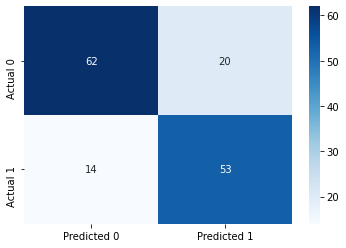

In [22]:
#Computing the accuracy
y_pred = model4.predict(Xtest)
print("Accuracy: ",accuracy_score(y_pred, ytest)*100)  

#Computing the ROC-AUC
y_pred_prob = model4.predict_proba(Xtest)[:,1]
fpr, tpr, auc_thresholds = roc_curve(ytest, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(ytest, y_pred))
print("Recall: ", recall_score(ytest, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(ytest, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

If we increase the value of `scale_pos_weight`, the model will focus on classifying positives more correctly. This will increase the recall (true positive rate) since the focus is on identifying all positives. However, this will lead to identifying positives aggressively, and observations 'similar' to observations of the positive class will also be predicted as positive resulting in an increase in false positives and a decrease in precision. See the trend below as we increase the value of `scale_pos_weight`.

### Precision & recall vs `scale_pos_weight`

>0 0.00 (0.00)
>1 0.77 (0.13)
>10 0.81 (0.09)
>100 0.85 (0.11)
>1000 0.85 (0.10)
>10000 0.90 (0.06)
>100000 0.90 (0.08)
>1000000 0.90 (0.06)
>10000000 0.91 (0.10)
>100000000 0.96 (0.03)
>1000000000 1.00 (0.00)


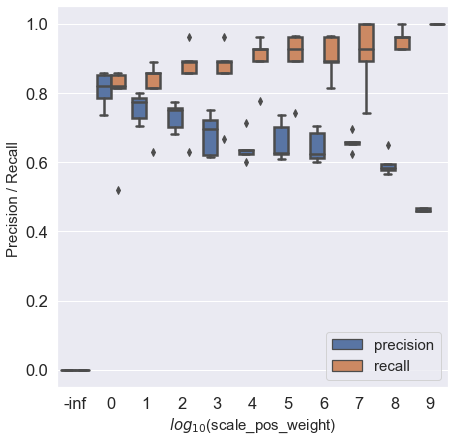

In [286]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0,1,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9]:
        key = '%.0f' % i
        models[key] = xgb.XGBClassifier(objective = 'binary:logistic',scale_pos_weight=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores_recall = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)
    scores_precision = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
    return list([scores_recall,scores_precision])

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results_recall, results_precision, names = list(), list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    scores_recall = scores[0]
    scores_precision = scores[1]
    # store the results
    results_recall.append(scores_recall)
    results_precision.append(scores_precision)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.2f (%.2f)' % (name, np.mean(scores_recall), np.std(scores_recall)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
sns.set(font_scale = 1.5)
pdata = pd.DataFrame(results_precision)
pdata.columns = list(['p1','p2','p3','p4','p5'])
pdata['metric'] = 'precision'
rdata = pd.DataFrame(results_recall)
rdata.columns = list(['p1','p2','p3','p4','p5'])
rdata['metric'] = 'recall'
pr_data = pd.concat([pdata,rdata])
pr_data.reset_index(drop=False,inplace= True)
#sns.boxplot(x="day", y="total_bill", hue="time",pr_data=tips, linewidth=2.5)
pr_data_melt=pr_data.melt(id_vars = ['index','metric'])
pr_data_melt['index']=pr_data_melt['index']-1
pr_data_melt['index'] = pr_data_melt['index'].astype('str')
pr_data_melt.replace(to_replace='-1',value =  '-inf',inplace=True)
sns.boxplot(x='index', y="value", hue="metric", data=pr_data_melt, linewidth=2.5)
plt.xlabel('$log_{10}$(scale_pos_weight)',fontsize=15)
plt.ylabel('Precision / Recall ',fontsize=15)
plt.legend(loc="lower right", frameon=True, fontsize=15)